In [1]:
!pip install opendatasets


<B> <Font size =15>1. Importing </font></b>


#<b>Importing required dependencies for data pre-processing and ETA</B>

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import calendar
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

#<b> importing required dependencies for train-test split, models and metrics

In [3]:
# Libraries for splitting data sets , scaling the numerical features , Encoding target and categorical features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,RobustScaler,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE # Handles unbalanced data set

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV ,TimeSeriesSplit# Finding the best hyper parameters for the model
#from sklearn.tree import plot_tree, DecisionTreeClassifier

from sklearn.decomposition import PCA # Dimensionality reduction needed after OneHotEncoding the categorical features

#  For Regression - Predicting future quantity demands
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


#For Classification - Predicting Customer Labels based on their transaction history
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Unsupervised learning to predict customer segmentation
from sklearn.cluster import KMeans , DBSCAN

# Metrics to validate the performances of the models
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_samples,silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_percentage_error

#<b><font size =15>2. Downloading dataset from kaggle</b></i>

In [3]:
od.download("https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci") # This cell needs kaggle user name and pass key

In [5]:
df_online=pd.read_csv("/content/online-retail-ii-uci/online_retail_II.csv")

In [6]:
# Keeping a spare copy of original dataset for any future use
df_online_copy=df_online.copy()

#<b><font size =15>3. Data pre-processing</font></b>

###<i>Data preprocessing is the first step in the machine learning pipeline. In this stage, the data is cleaned and prepared for modeling by handling duplicated entries, outliers, and missing values.
</i>

---



##<b> Basic Analysis</b>

In [7]:
df_online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
original_length=len(df_online)
original_length

1067371

In [9]:
df_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [10]:
df_online.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


###<i> Missing/Null values</i>

In [11]:
missing_data=df_online.isnull().sum()
missing_data

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


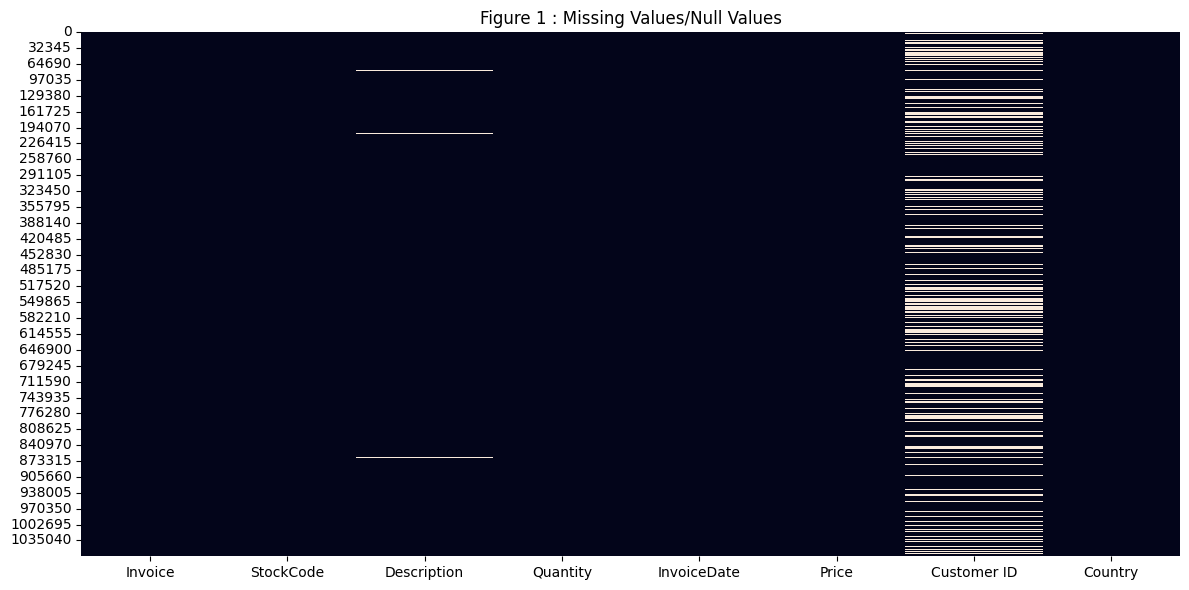

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_online.isnull(),cbar=False)
plt.title('Figure 1 : Missing Values/Null Values')
plt.tight_layout()
plt.show()

###<i>Duplicated Entries<br>Some columns like Country,Description, InvoiceDate will naturally repeat and should not alone define a duplicate. So, when trying to identify real duplicate transactions, we want to look at a combination of columns that make an entry uniquely meaningful.</i>

In [13]:
df_duplicate=df_online.duplicated(subset=['Invoice','StockCode','Quantity','Price','Customer ID',],keep='first')
print(f'There are {df_duplicate.sum()} entries that are duplicated')

There are 34339 entries that are duplicated


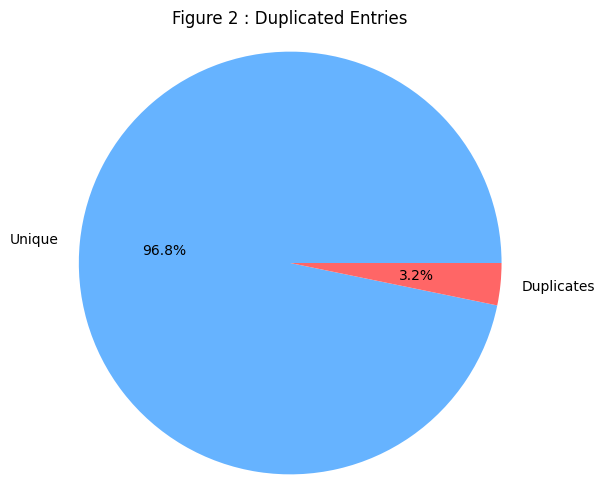

In [14]:
total_duplicate=df_duplicate.sum()
total_unique=len(df_online)-total_duplicate
if total_duplicate:
  sizes=[total_unique,total_duplicate]
  labels=['Unique','Duplicates']
  colors=['#66b3ff','#ff6666']
  plt.figure(figsize=(6,6))
  plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%')
  plt.title('Figure 2 : Duplicated Entries')
  plt.axis('equal')
  plt.show()

###<i>Outliers</i>

In [15]:
numerical_columns=df_online.select_dtypes(include=[np.number]).columns #selecting numerical columns to findout if there is any outliers
numerical_columns

Index(['Quantity', 'Price', 'Customer ID'], dtype='object')

In [16]:
numerical_columns=numerical_columns[:2] # Normally, an Customer ID is just an identifier (like a unique code), so outliers don’t apply unless
numerical_columns

Index(['Quantity', 'Price'], dtype='object')

In [17]:
melt_data=df_online.melt(id_vars='Invoice',value_vars=numerical_columns)
melt_data

,Invoice,variable,value
0,489434,Quantity,12.00
1,489434,Quantity,12.00
2,489434,Quantity,12.00
3,489434,Quantity,48.00
4,489434,Quantity,24.00
...,...,...,...
2134737,581587,Price,2.10
2134738,581587,Price,4.15
2134739,581587,Price,4.15
2134740,581587,Price,4.95


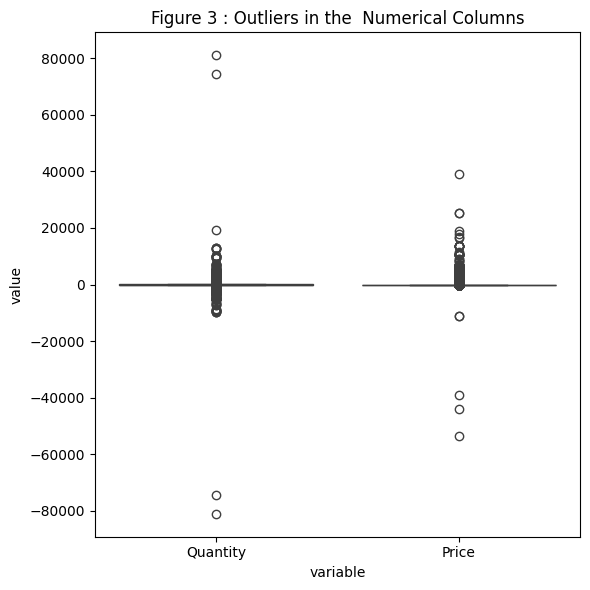

In [18]:
plt.figure(figsize=(6,6))
sns.boxplot(x='variable',y='value',data=melt_data)
plt.title('Figure 3 : Outliers in the  Numerical Columns')
plt.tight_layout()
plt.show()

####<i><font color="blue">Note:<br> Exploring in depth,the above plot shows that both Quantity and Unitprice have outliers in negative side.<br>Reasons:<br><u>Quantity   :</u> <br>Nagative value indicates Quantity returns or cancellations<br></font></i><i><font color ='red'><u>Price  :</u><br> Normally Unit Price is an non negative numerical value. It might be a manual refund entry or mistake<i></i></font></i>

###<b>Quantity-Returns with proper credit note in Invoice</b>

In [19]:
df_quantity_return=df_online[(df_online['Quantity']<0) & (df_online['Invoice'].str.contains('C'))]
df_quantity_return.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [20]:
print(f'There are {len(df_quantity_return)} entries that are returns')

There are 19493 entries that are returns


In [21]:
df_quantity_return['Country'].value_counts()# displaying country and its total returned entries

,count
Country,
United Kingdom,16649
Germany,921
EIRE,512
France,389
USA,126
Australia,98
Japan,97
Channel Islands,95
Spain,91


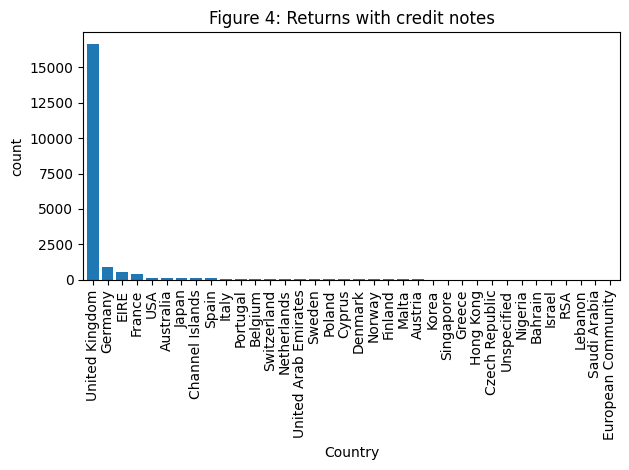

In [22]:
df_quantity_return['Country'].value_counts().plot(kind='bar',width=0.8)
plt.xlabel("Country")
plt.ylabel("count")
plt.title("Figure 4: Returns with credit notes")
#plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# Checking all the -ve Quantities are returned Quantities
len(df_online[df_online['Quantity']<0] )== len(df_online[df_online['Invoice'].str.contains('C')])

False

###<font color='black'><b> Quantity-Returns with out proper credit notes in the invoice</b></font>

In [24]:
# Finding -ve Quantities with Invoice does not contain 'C'
df_return_not_c=df_online[(df_online['Quantity']<0 ) & ~(df_online['Invoice'].str.contains('C'))]

In [25]:
len(df_return_not_c)

3457

In [26]:
df_return_not_c.Country.value_counts()# Only transactions from the UK have negative Quantity values where the Invoice does not start with 'C'.

,count
Country,
United Kingdom,3457


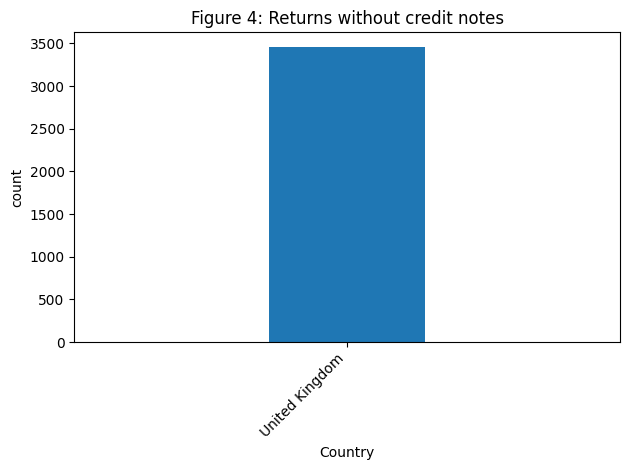

In [27]:
df_return_not_c.Country.value_counts().plot(kind='bar',width=0.2)
plt.xlabel("Country")
plt.ylabel("count")
plt.title("Figure 4: Returns without credit notes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###<b> Price -outliers</b>

In [28]:
price_outliers=df_online[df_online['Price']<=0]

In [29]:
len(price_outliers)#Total Outliers in Price columns

6207

In [30]:
total_price=len(df_online)-len(price_outliers)
total_price,len(price_outliers),df_online.Price.count()

(1061164, 6207, np.int64(1067371))

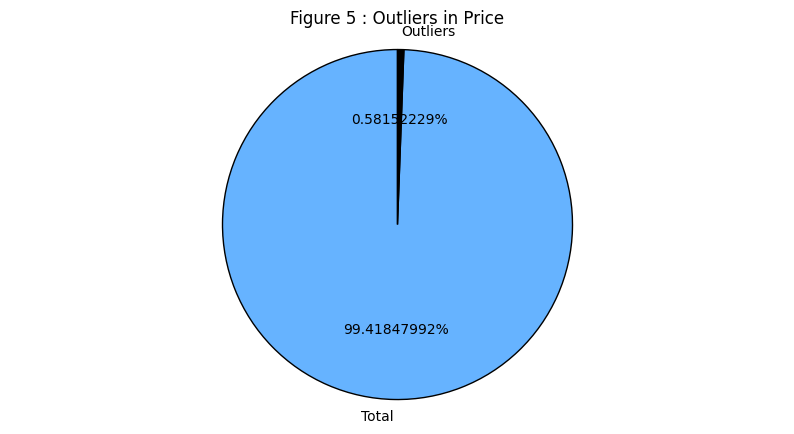

In [31]:
price_count=[total_price,len(price_outliers)]
price_labels=['Total','Outliers']
price_colors=['#66b3ff','black']
plt.figure(figsize=(10,5))
plt.pie(price_count,labels=price_labels,colors=price_colors,autopct='%1.8f%%',
        wedgeprops={'edgecolor':'black','linewidth':1},startangle=90)
plt.title('Figure 5 : Outliers in Price')
plt.axis('equal')
plt.show()


#<b> 2. Data Cleaning </b>

 * The data type of InvoiceDate is currently an object. To extract valuable information like year, month, or day, it needs to be converted into a proper pandas datetime format.

* Dropping Duplicate entries
* Dropping Missing Values ie., missing values in description columns
* Removing Negative price outliers
* Removing entries which does not have a proper return note
* Converting Customer id from numerical to string then imputing customer id from null to 'unknown-customer'








In [32]:
df_online.InvoiceDate.dtype

dtype('O')

In [33]:
df_online['InvoiceDate']=pd.to_datetime(df_online['InvoiceDate'])

In [34]:
df_online.InvoiceDate.dt.date.value_counts()

,count
InvoiceDate,
2010-12-06,7756
2010-12-01,6216
2010-12-07,5926
2010-12-09,5782
2010-12-05,5450
...,...
2010-06-20,440
2009-12-05,402
2010-01-06,294


In [35]:
#Dropping Null/Missing Values
df_online.dropna(subset=['Description','Customer ID'],inplace=True)

In [36]:
#Total length before and after dropping
print(f'Original entries:{original_length}, after dropping Missing/Null :{len(df_online)},so {original_length-len(df_online)} entries were dropped')


Original entries:1067371, after dropping Missing/Null :824364,so 243007 entries were dropped


In [37]:
#Dropping duplicated entries
df_online.drop_duplicates(inplace=True)

In [38]:
#Length after dropping
print(f'Entries after dropping duplicates :{len(df_online)},so {df_duplicate.sum()} were dropped')

Entries after dropping duplicates :797885,so 34339 were dropped


In [39]:
len(df_online)

797885

In [40]:
#dropping entries with no proper return notes
df_online=df_online[~((df_online['Quantity']<0) & ~(df_online['Invoice'].str.contains('C')))]


In [41]:
len(df_online)

797885

In [42]:
df_online[(df_online['Quantity']<0) & ~(df_online['Invoice'].str.contains('C'))].count()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [43]:
len(df_online)

797885

In [44]:
# Dropping entries based on the quantity features that are below less than 10 percentages and 90 percentages
# The customers may be whole-sale purchaser
knn_df_reg=df_online[(df_online['Quantity']<df_online['Quantity'].quantile(0.90))&(df_online['Quantity']>df_online['Quantity'].quantile(0.10))]

In [45]:
#dropping quantity =0
df_online=df_online[(df_online['Quantity']>0)|(df_online['Quantity']<0)]

In [46]:
#Dropping outliers - negative price outliers or keeping only non-negative price
df_online=df_online[df_online['Price']>0]

In [47]:
len(df_online)

797815

In [48]:
## finding suspisious return entry with no previous purchase means wrong entries
returns=df_online[df_online['Quantity']<0]
purchase=df_online[df_online['Quantity']>0]
check_wrong=returns.merge(purchase[['Customer ID','StockCode']],on=['Customer ID','StockCode'],how='left',indicator=True)
check_wrong=check_wrong[check_wrong['_merge']=='left_only'].reset_index(drop=True)


In [49]:
check_wrong.sort_values(by='Quantity',ascending=True)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,_merge
1258,C552995,M,Manual,-1350,2011-05-12 15:19:00,0.16,18133.0,United Kingdom,left_only
1241,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2011-04-18 13:08:00,2.55,15749.0,United Kingdom,left_only
1407,C570708,M,Manual,-600,2011-10-12 10:11:00,0.19,12908.0,United Kingdom,left_only
1348,C564899,M,Manual,-480,2011-08-31 11:31:00,0.22,14646.0,Netherlands,left_only
695,C503999,M,Manual,-408,2010-04-09 11:36:00,0.33,16754.0,United Kingdom,left_only
...,...,...,...,...,...,...,...,...,...
28,C489583,72802C,VANILLA SCENT CANDLE JEWELLED BOX,-1,2009-12-01 13:47:00,4.25,14621.0,United Kingdom,left_only
27,C489583,72807B,SET/3 OCEAN SCENT CANDLE JEWEL BOX,-1,2009-12-01 13:47:00,4.25,14621.0,United Kingdom,left_only
26,C489578,21481,FAWN BLUE HOT WATER BOTTLE,-1,2009-12-01 13:40:00,2.95,17091.0,United Kingdom,left_only
20,C489553,35004S,SET OF 3 SILVER FLYING DUCKS,-1,2009-12-01 12:41:00,6.35,13545.0,United Kingdom,left_only


In [50]:
df_online[df_online['Invoice'].isin(check_wrong['Invoice'])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
285,C489476,22149,FELTCRAFT 6 FLOWER FRIENDS,-6,2009-12-01 10:55:00,2.10,13293.0,United Kingdom
318,C489504,85083,KISS REINDEER SCANDINAVIAN STOCKING,-6,2009-12-01 11:10:00,2.55,13916.0,United Kingdom
399,C489518,20892,SET/3 TALL GLASS CANDLE HOLDER PINK,-2,2009-12-01 11:35:00,12.75,15461.0,United Kingdom
400,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom
401,C489518,22138,BAKING SET 9 PIECE RETROSPOT,-1,2009-12-01 11:35:00,4.95,15461.0,United Kingdom
...,...,...,...,...,...,...,...,...
1059770,C581145,35970,ZINC FOLKART SLEIGH BELLS,-12,2011-12-07 13:48:00,1.69,17490.0,United Kingdom
1059771,C581145,23249,VINTAGE RED ENAMEL TRIM PLATE,-9,2011-12-07 13:48:00,1.49,17490.0,United Kingdom
1059772,C581145,23250,VINTAGE RED TRIM ENAMEL BOWL,-38,2011-12-07 13:48:00,1.04,17490.0,United Kingdom
1063056,C581323,21533,RETROSPOT LARGE MILK JUG,-1,2011-12-08 11:53:00,4.25,14442.0,Channel Islands


In [51]:
#Removing return entries which are not appeared in purchase
df_online=df_online[~df_online['Invoice'].isin(check_wrong['Invoice'])]
len(df_online)

794977

In [52]:
#Total length after cleaning
print(f'Entries after Data Cleaning ie., Rmoving Missing Value,Duplicates,Negative price and Quantity outliers  are :{len(df_online)}')
print(f'Entries {original_length-len(df_online)} were removed')

Entries after Data Cleaning ie., Rmoving Missing Value,Duplicates,Negative price and Quantity outliers  are :794977
Entries 272394 were removed


(np.float64(-1.0999966771104106),
 np.float64(1.0999998218688203),
 np.float64(-1.0999957912287175),
 np.float64(1.0999997995823199))

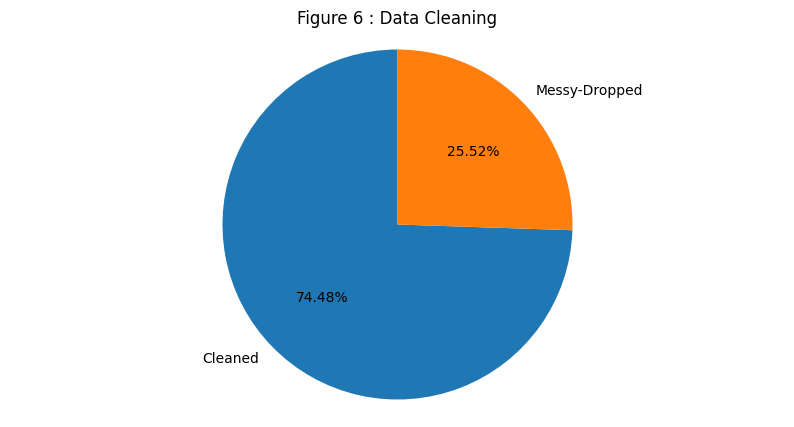

In [53]:
length=[len(df_online),original_length-len(df_online)]
labels=['Cleaned','Messy-Dropped']
colors=['#66b3ff','black']
plt.figure(figsize=(10,5))
plt.pie(length,labels=labels,autopct='%1.2f%%'
       ,startangle=90)
plt.title('Figure 6 : Data Cleaning')
plt.axis('equal')

In [54]:
df_online.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [55]:
# Final length after cleaning
len(df_online)

794977

In [56]:
# Taking sample of 25000 entries only
df_online=df_online.sample(n=25000, random_state=42).reset_index(drop=True)




#<b><i><font size=15>4. Exploratory Data Analysis</font></b></i>

###<b> EDA- Exploratory Data Analysis involves in detaied analysis of :<br> Explore Data balance, Class Balance, Other relationship like correlations beteween numerical features and time series analysis</b>

##<b>  Exploring Data set after Data Cleaning / pre-processing(Detailed Analysis)</b>

In [57]:
#Total length
len(df_online)

25000

In [58]:
df_online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,568793,85199L,LARGE HANGING IVORY & RED WOOD BIRD,12,2011-09-29 09:55:00,0.65,16011.0,United Kingdom
1,559057,22784,LANTERN CREAM GAZEBO,6,2011-07-06 09:46:00,4.95,13089.0,United Kingdom
2,516618,48185,DOORMAT FAIRY CAKE,6,2010-07-21 16:01:00,7.49,12835.0,United Kingdom
3,540242,21181,PLEASE ONE PERSON METAL SIGN,3,2011-01-05 15:30:00,2.10,15046.0,United Kingdom
4,569714,21932,SCANDINAVIAN PAISLEY PICNIC BAG,1,2011-10-05 17:28:00,1.65,18033.0,United Kingdom


In [59]:
df_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      25000 non-null  object        
 1   StockCode    25000 non-null  object        
 2   Description  25000 non-null  object        
 3   Quantity     25000 non-null  int64         
 4   InvoiceDate  25000 non-null  datetime64[ns]
 5   Price        25000 non-null  float64       
 6   Customer ID  25000 non-null  float64       
 7   Country      25000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.5+ MB


Note: Now InvoiceDate feature is in date and time data type

In [60]:
df_online.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,25000.000000,25000,25000.000000,25000.000000
mean,13.361960,2011-01-03 18:18:35.623200256,4.048215,15316.046600
min,-576.000000,2009-12-01 07:45:00,0.040000,12346.000000
25%,2.000000,2010-07-04 11:19:00,1.250000,13969.000000
50%,5.000000,2010-12-05 15:09:00,1.950000,15241.000000
75%,12.000000,2011-07-31 14:27:45,3.750000,16794.000000
max,7008.000000,2011-12-09 12:50:00,10953.500000,18287.000000
std,78.472793,NaN,77.335068,1697.112729


In [61]:
# Checking Null values
df_online.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [62]:
#Checking any duplicate entries still present in the data set
df_online.duplicated().sum()

np.int64(0)

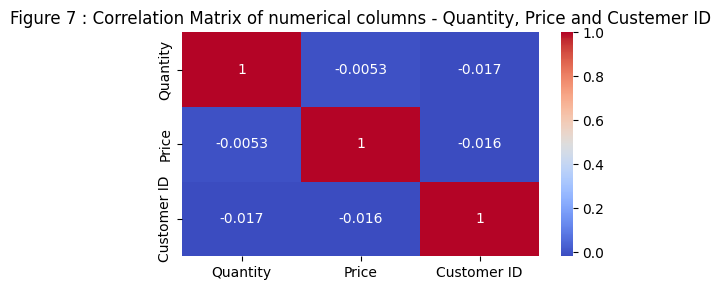

In [63]:
# correlation between numerical columns
plt.figure(figsize=(5,3))
sns.heatmap(df_online.select_dtypes(include=[np.number]).corr(),annot=True,cmap='coolwarm')
plt.title('Figure 7 : Correlation Matrix of numerical columns - Quantity, Price and Custemer ID')
plt.tight_layout()
plt.show()

Figure 7 shows that there is no correlation between Quantity and Unit Price. In other words, the unit price remains constant regardless of the quantity.

In [64]:
df_quantity_groups=df_online['Quantity'].value_counts()
df_quantity_groups.sort_index(inplace=True)
df_quantity_groups


,count
Quantity,
-576,2
-400,2
-200,1
-168,1
-150,1
...,...
2400,1
3744,1
4320,1


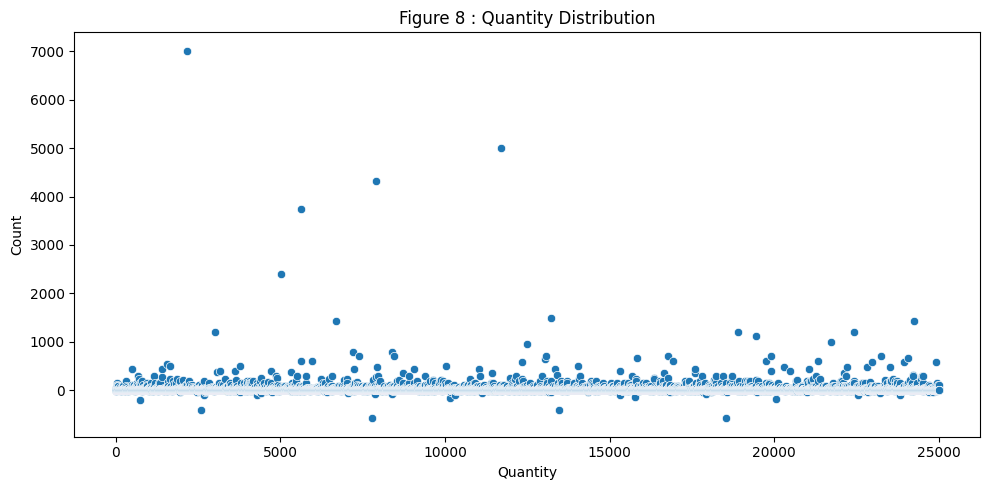

In [65]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df_online.Quantity.index, y=df_online.Quantity.values)
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.title('Figure 8 : Quantity Distribution')
plt.tight_layout()
plt.show()

Figure 8 shows that there are outliers on both the positive and negative sides. Negative quantities likely indicate returns or cancellations.

In [66]:
print(f'Maximum Quantity ordered were: {np.max(df_online.Quantity)},and minimum is :{np.min(df_online.Quantity)}')

Maximum Quantity ordered were: 7008,and minimum is :-576


In [67]:
df_online.loc[df_online['Quantity']==df_online.Quantity.max()].reset_index(drop=True)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,518505,21096,SET/6 FRUIT SALAD PAPER PLATES,7008,2010-08-09 13:10:00,0.13,14277.0,France


In [68]:
# grouping customer and their overall purchase
customer_group=df_online.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False)
customer_group

,Quantity
Customer ID,
14646.0,12084
13687.0,8736
18102.0,7573
14277.0,7066
14156.0,5886
...,...
17353.0,-30
17567.0,-44
15971.0,-54


###Displaying return/ cancelled entries( both properly and not properly notified )

In [69]:
return_entries=df_online[df_online['Quantity']<=0][['Customer ID','Invoice','Description','Quantity','Price','Country','InvoiceDate']].reset_index()
return_entries

,index,Customer ID,Invoice,Description,Quantity,Price,Country,InvoiceDate
0,7,13750.0,C536215,BLACK RECORD COVER FRAME,-7,3.39,United Kingdom,2010-11-30 13:37:00
1,14,12651.0,C531446,GUMBALL COAT RACK,-1,2.55,France,2010-11-08 12:37:00
2,18,12982.0,C507217,GLASS CHALICE GREEN LARGE,-1,2.55,United Kingdom,2010-05-06 18:02:00
3,172,14598.0,C509015,SWEETIES STICKERS,-2,0.85,United Kingdom,2010-05-19 13:36:00
4,214,15358.0,C513406,CAKE STAND WHITE TWO TIER LACE,-1,8.50,United Kingdom,2010-06-24 11:56:00
...,...,...,...,...,...,...,...,...
482,24528,14769.0,C494334,"POPCORN HOLDER , LARGE",-2,1.65,United Kingdom,2010-01-13 12:16:00
483,24619,13338.0,C512845,CARRIAGE,-1,50.00,United Kingdom,2010-06-18 11:40:00
484,24703,14586.0,C551180,MAGIC DRAWING SLATE BAKE A CAKE,-24,0.42,United Kingdom,2011-04-26 17:32:00
485,24820,14146.0,C542426,PIG KEYRING WITH LIGHT & SOUND,-24,1.25,United Kingdom,2011-01-28 09:32:00


<Figure size 1000x500 with 0 Axes>

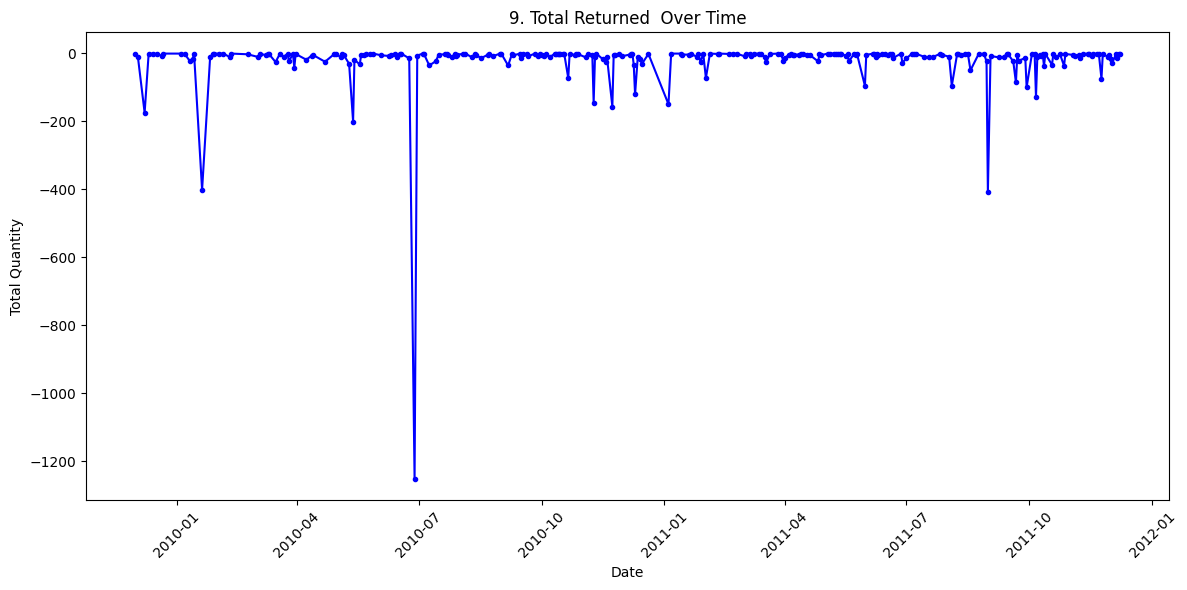

In [70]:
plt.figure(figsize=(10,5))
negative_quantity_by_date = return_entries.groupby(return_entries['InvoiceDate'].dt.date)['Quantity'].sum()
plt.figure(figsize=(12,6))
plt.plot(negative_quantity_by_date.index, negative_quantity_by_date.values, marker='.', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.title('9. Total Returned  Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Figure 9 shows a significant number of returns around October 2010, February/March 2011, and November/December 2012. This suggests that customers tend to return items closer to Christmas or shortly after the holiday season.

In [71]:
print('Top 10 customers who returned huge quantities are:')
return_entries.sort_values(by='Quantity',ascending=True).head(10)

Top 10 customers who returned huge quantities are:


,index,Customer ID,Invoice,Description,Quantity,Price,Country,InvoiceDate
368,18528,16754.0,C513771,SET/20 RED SPOTTY PAPER NAPKINS,-576,0.64,United Kingdom,2010-06-28 13:49:00
145,7778,16754.0,C513771,SKULLS STICKERS,-576,0.72,United Kingdom,2010-06-28 13:49:00
267,13458,14156.0,C494973,LITTLE FLOWER SHOPPER BAG,-400,1.06,EIRE,2010-01-20 11:06:00
45,2591,12931.0,C564940,REVOLVER WOODEN RULER,-400,1.65,United Kingdom,2011-08-31 13:10:00
12,750,12931.0,C508134,GLITTER HANGING BUTTERFLY STRING,-200,2.10,United Kingdom,2010-05-13 10:56:00
399,20062,15971.0,C491023,"SWISS ROLL TOWEL, PINK SPOTS",-168,2.55,United Kingdom,2009-12-08 18:57:00
197,10166,17389.0,C540109,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,-150,2.95,United Kingdom,2011-01-04 17:12:00
311,15779,12454.0,C531557,FELTCRAFT DOLL ROSIE,-144,2.55,Spain,2010-11-09 10:06:00
468,23809,14680.0,C568884,JUMBO BAG RED RETROSPOT,-100,1.79,United Kingdom,2011-09-29 12:49:00
201,10310,13694.0,C555006,GARDENERS KNEELING PAD CUP OF TEA,-96,1.45,United Kingdom,2011-05-31 09:51:00


In [72]:
print(f'Maximum quantity Cancelled/returned were: {np.min(return_entries.Quantity)},and minimum is :{np.max(return_entries.Quantity)}')

Maximum quantity Cancelled/returned were: -576,and minimum is :-1


###Finding Total number of customers(unique)

In [73]:
df_online['Customer ID'].value_counts()

,count
Customer ID,
17841.0,375
14911.0,341
14606.0,243
12748.0,199
14096.0,157
...,...
14983.0,1
14336.0,1
15289.0,1


In [74]:
df_online['Customer ID'].nunique()

4198

##Finding the unique country names present in the dataset.

In [75]:
df_online['Country'].value_counts()

,count
Country,
United Kingdom,22453
Germany,561
EIRE,500
France,393
Netherlands,158
Spain,114
Switzerland,100
Belgium,98
Portugal,85


In [76]:
print(f'There are {df_online.Country.nunique()} unique countries present in the data set')

There are 38 unique countries present in the data set


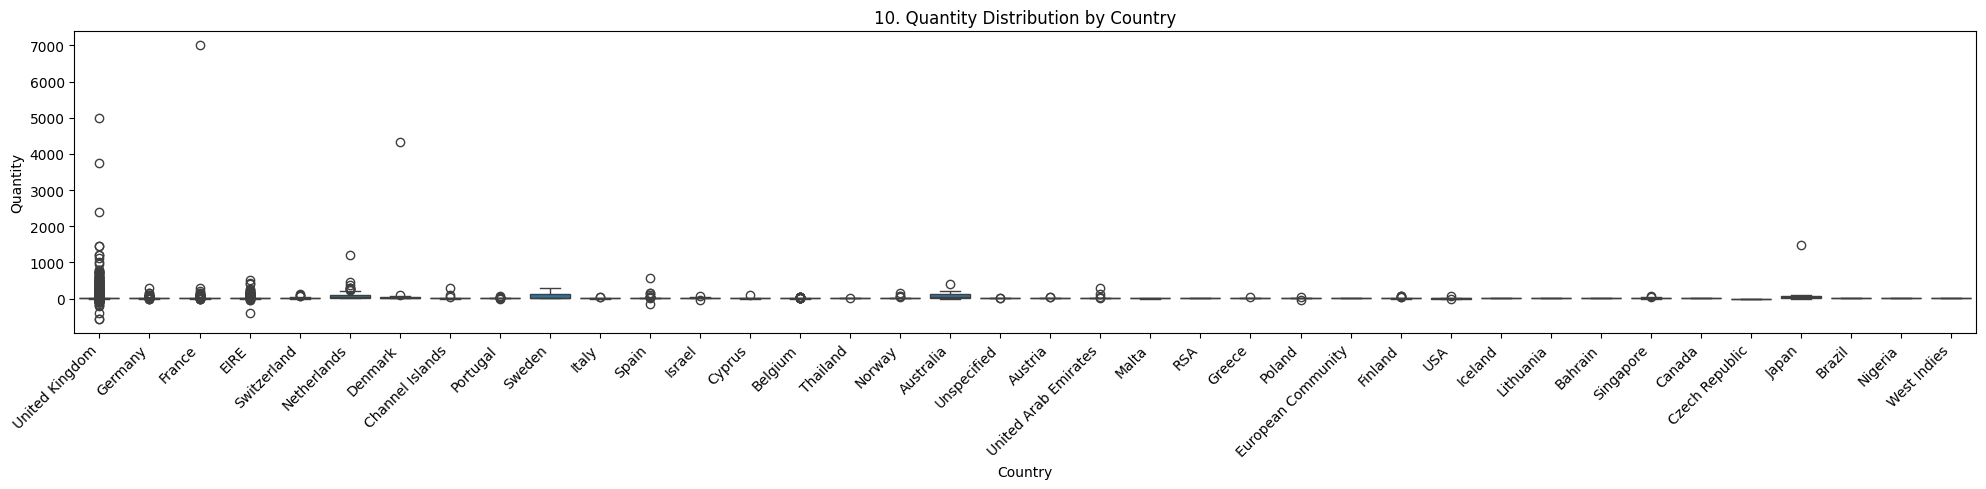

In [77]:
plt.figure(figsize=(20,5))
sns.boxplot(x='Country', y='Quantity', data=df_online)
plt.xlabel('Country')
plt.ylabel('Quantity')
plt.title('10. Quantity Distribution by Country')
plt.xticks(rotation=45,ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

Figure 10 shows that customers from the UK, Denmork and France made high-volume purchases and also returned items

### Finding unique products

In [78]:
print(f'Total number unique Products:{df_online.Description.nunique()}')

Total number unique Products:3633


###Top selling products

In [79]:
df_online.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)


,Quantity
Description,
SET/6 FRUIT SALAD PAPER PLATES,7020
MULTICOLOUR SPRING FLOWER MUG,5232
BLUE PAISLEY POCKET BOOK,4344
BROCADE RING PURSE,4176
THE KING GIFT BAG,3744
GROW A FLYTRAP OR SUNFLOWER IN TIN,3192
ASSORTED COLOUR BIRD ORNAMENT,3021
PACK OF 72 RETROSPOT CAKE CASES,2915
POPCORN HOLDER,2576


###Most frequent Cutomers

In [80]:
frequent_customers=df_online['Customer ID'].value_counts().sort_values(ascending=False)
frequent_customers

,count
Customer ID,
17841.0,375
14911.0,341
14606.0,243
12748.0,199
14096.0,157
...,...
16404.0,1
15964.0,1
14065.0,1


In [81]:
df_online[df_online['Customer ID']==frequent_customers.index[0]]['Description'].value_counts()

,count
Description,
CHARLOTTE BAG SUKI DESIGN,6
LUNCH BAG RED RETROSPOT,4
SUKI SHOULDER BAG,4
CHILLI LIGHTS,3
ROUND SNACK BOXES SET OF4 WOODLAND,3
...,...
WOOD STAMP SET FLOWERS,1
SET OF 5 LUCKY CAT MAGNETS,1
TV DINNER TRAY AIR HOSTESS,1


<font color='green'>So these are the products that most frequent customer bought</green>

### Country of the most frequent customers

In [82]:
df_online.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False).head(10).rename('Number-of-customers')

,Number-of-customers
Country,
United Kingdom,3801
Germany,86
France,67
Spain,25
Belgium,23
Portugal,18
Switzerland,17
Italy,16
Sweden,14


###Customers with highest spending

In [83]:
high_spend_customer=df_online.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False)
high_spend_customer


,Quantity
Customer ID,
14646.0,12084
13687.0,8736
18102.0,7573
14277.0,7066
14156.0,5886
...,...
17353.0,-30
17567.0,-44
15971.0,-54


In [84]:
df_online[df_online['Customer ID']==high_spend_customer.index[0]].reset_index(drop=True)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,565967,20750,RED RETROSPOT MINI CASES,12,2011-09-08 11:27:00,6.35,14646.0,Netherlands
1,563076,21561,DINOSAUR LUNCH BOX WITH CUTLERY,60,2011-08-11 16:12:00,2.10,14646.0,Netherlands
2,578140,22631,CIRCUS PARADE LUNCH BOX,64,2011-11-23 10:58:00,1.65,14646.0,Netherlands
3,513647,21432,SET OF 3 CASES WOODLAND DESIGN,36,2010-06-28 08:28:00,5.45,14646.0,Netherlands
4,575508,22100,SKULLS SQUARE TISSUE BOX,144,2011-11-10 10:32:00,0.39,14646.0,Netherlands
...,...,...,...,...,...,...,...,...
107,534379,22402,MAGNETS PACK OF 4 VINTAGE COLLAGE,2,2010-11-22 12:36:00,1.25,14646.0,Netherlands
108,576664,21671,RED SPOT CERAMIC DRAWER KNOB,96,2011-11-16 11:41:00,1.25,14646.0,Netherlands
109,541206,22326,ROUND SNACK BOXES SET OF4 WOODLAND,144,2011-01-14 12:24:00,2.55,14646.0,Netherlands
110,563076,23110,PARISIENNE KEY CABINET,16,2011-08-11 16:12:00,4.95,14646.0,Netherlands


<font color='green'>Top Spending Customer was from Netherlands</green>

In [85]:
least_spending_customer=df_online[(df_online['Quantity']>=0) & (df_online['Quantity']<10)]
least_spending_customer.sort_values(by='Quantity',ascending=True)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
15628,527420,21900,"KEY FOB , SHED",1,2010-10-17 15:50:00,0.65,16549.0,United Kingdom
15625,523286,20764,ABSTRACT CIRCLES SKETCHBOOK,1,2010-09-21 12:07:00,3.75,14716.0,United Kingdom
55,509743,48188,DOOR MAT WELCOME PUPPIES,1,2010-05-25 13:21:00,7.49,17841.0,United Kingdom
24973,544463,21623,VINTAGE UNION JACK MEMOBOARD,1,2011-02-20 14:31:00,9.95,12988.0,United Kingdom
24968,513750,20675,BLUE SPOTTY BOWL,1,2010-06-28 12:38:00,1.25,17019.0,United Kingdom
...,...,...,...,...,...,...,...,...
8860,549970,22844,VINTAGE CREAM DOG FOOD CONTAINER,9,2011-04-13 14:25:00,8.50,15026.0,United Kingdom
19644,491756,72756,FAIRY CAKE CANDLES,9,2009-12-14 12:18:00,1.49,15329.0,United Kingdom
94,570458,72741,GRAND CHOCOLATECANDLE,9,2011-10-10 15:39:00,1.45,14535.0,United Kingdom
19723,527078,15056BL,EDWARDIAN PARASOL BLACK,9,2010-10-14 15:26:00,5.95,15160.0,United Kingdom


<font color='green'> It appears that most of the least spending customer are from the UK and have no Customer ID'</font>



###Analysing Years

In [86]:
print(f' Initial Entry Date : {np.min(df_online.InvoiceDate)}')
print(f' Final Entry Date : {np.max(df_online.InvoiceDate)} ')

 Initial Entry Date : 2009-12-01 07:45:00
 Final Entry Date : 2011-12-09 12:50:00 


In [87]:
print(f'Total time span :{np.max(df_online.InvoiceDate)-np.min(df_online.InvoiceDate)}')

Total time span :738 days 05:05:00


In [88]:
df_online.InvoiceDate.dt.year.nunique()

3

In [89]:
df_online.InvoiceDate.dt.year.value_counts()

,count
InvoiceDate,
2010,12185
2011,11861
2009,954


### Highest sale  months

In [90]:
highest_sale_month=df_online.groupby(df_online.InvoiceDate.dt.month)['Quantity'].sum()
highest_sale_month.index=highest_sale_month.index.map(lambda x: calendar.month_name[x])
highest_sale_month=highest_sale_month.sort_values(ascending=False)
highest_sale_month.index.name='Month'
highest_sale_month.name='Total Qty Sales'
highest_sale_month

,Total Qty Sales
Month,
November,43022
September,41674
October,36007
August,31099
December,30826
July,23768
June,23765
March,22383
January,21874


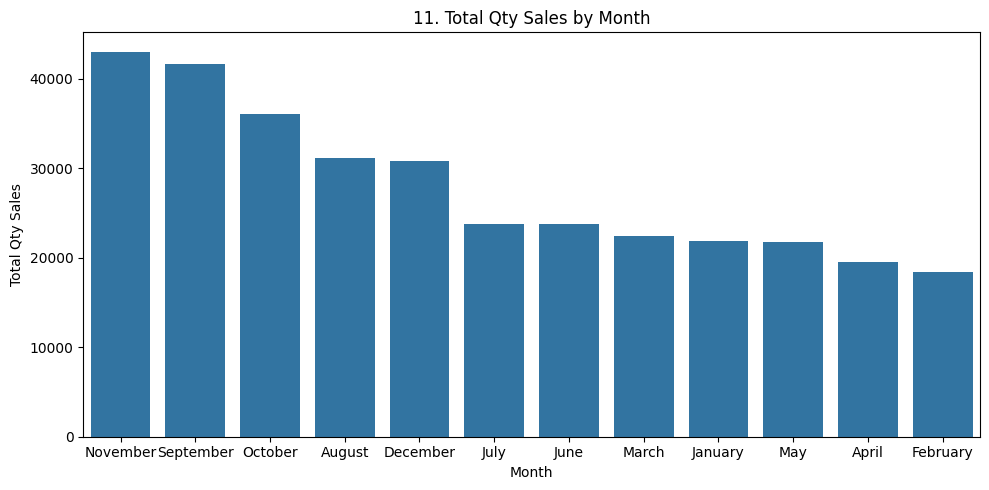

In [91]:
plt.figure(figsize=(10,5))
sns.barplot(x=highest_sale_month.index,y=highest_sale_month.values)
plt.xlabel('Month')
plt.ylabel('Total Qty Sales')
plt.title('11. Total Qty Sales by Month')
plt.tight_layout()
plt.show()

### Dates with highest quantities ordered

In [92]:
df_online. groupby('InvoiceDate')['Quantity'].sum().sort_values(ascending=False).head()

,Quantity
InvoiceDate,
2010-09-27 16:30:00,8736
2010-08-09 13:10:00,7008
2010-01-21 15:11:00,4320
2011-02-11 11:22:00,2400
2011-05-12 10:13:00,1490


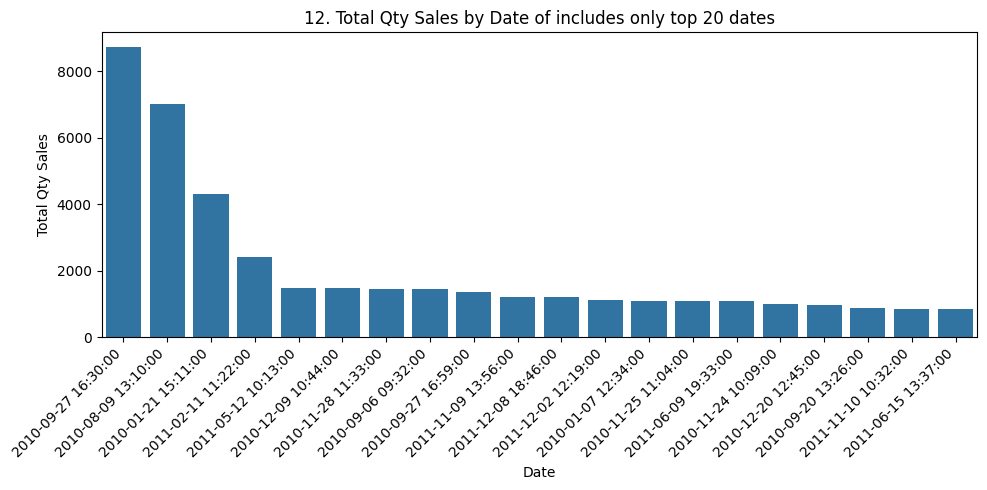

In [93]:
plt.figure(figsize=(10,5))
sns.barplot(x=df_online.groupby('InvoiceDate')['Quantity'].sum().sort_values(ascending=False).head(20).index,y=df_online.groupby('InvoiceDate')['Quantity'].sum().sort_values(ascending=False).head(20).values)
plt.xlabel('Date')
plt.ylabel('Total Qty Sales')
plt.title('12. Total Qty Sales by Date of includes only top 20 dates')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

###Fast moving product in each month

In [94]:
top_sell_monthly=(df_online.groupby(df_online['InvoiceDate'].dt.month)['Description'].agg(lambda x: x.value_counts().idxmax()))
top_sell_monthly.index=top_sell_monthly.index.map(lambda x: calendar.month_name[x])
top_sell_monthly.index.name='Month'
top_sell_monthly.name='Top Selling Product'
top_sell_monthly

,Top Selling Product
Month,
January,WHITE HANGING HEART T-LIGHT HOLDER
February,WHITE HANGING HEART T-LIGHT HOLDER
March,WHITE HANGING HEART T-LIGHT HOLDER
April,WHITE HANGING HEART T-LIGHT HOLDER
May,PARTY BUNTING
June,JUMBO BAG STRAWBERRY
July,WHITE HANGING HEART T-LIGHT HOLDER
August,JUMBO BAG RED RETROSPOT
September,WHITE HANGING HEART T-LIGHT HOLDER


In [95]:
qty=[]
for i in range(1,13):
  total=df_online[(df_online['Description']==top_sell_monthly.values[i-1])&(df_online['InvoiceDate'].dt.month==i)]['Quantity'].sum()
  qty.append(total)
qty


[np.int64(208),
 np.int64(91),
 np.int64(190),
 np.int64(154),
 np.int64(71),
 np.int64(241),
 np.int64(249),
 np.int64(336),
 np.int64(394),
 np.int64(108),
 np.int64(372),
 np.int64(143)]

In [96]:
for i, value in enumerate(top_sell_monthly):
    #plt.text(i, value + 5, str(value), ha='center')
    print(i,value)

0 WHITE HANGING HEART T-LIGHT HOLDER
1 WHITE HANGING HEART T-LIGHT HOLDER
2 WHITE HANGING HEART T-LIGHT HOLDER
3 WHITE HANGING HEART T-LIGHT HOLDER
4 PARTY BUNTING
5 JUMBO BAG STRAWBERRY
6 WHITE HANGING HEART T-LIGHT HOLDER
7 JUMBO BAG RED RETROSPOT
8 WHITE HANGING HEART T-LIGHT HOLDER
9 REGENCY CAKESTAND 3 TIER
10 PAPER CHAIN KIT 50'S CHRISTMAS 
11 WHITE HANGING HEART T-LIGHT HOLDER


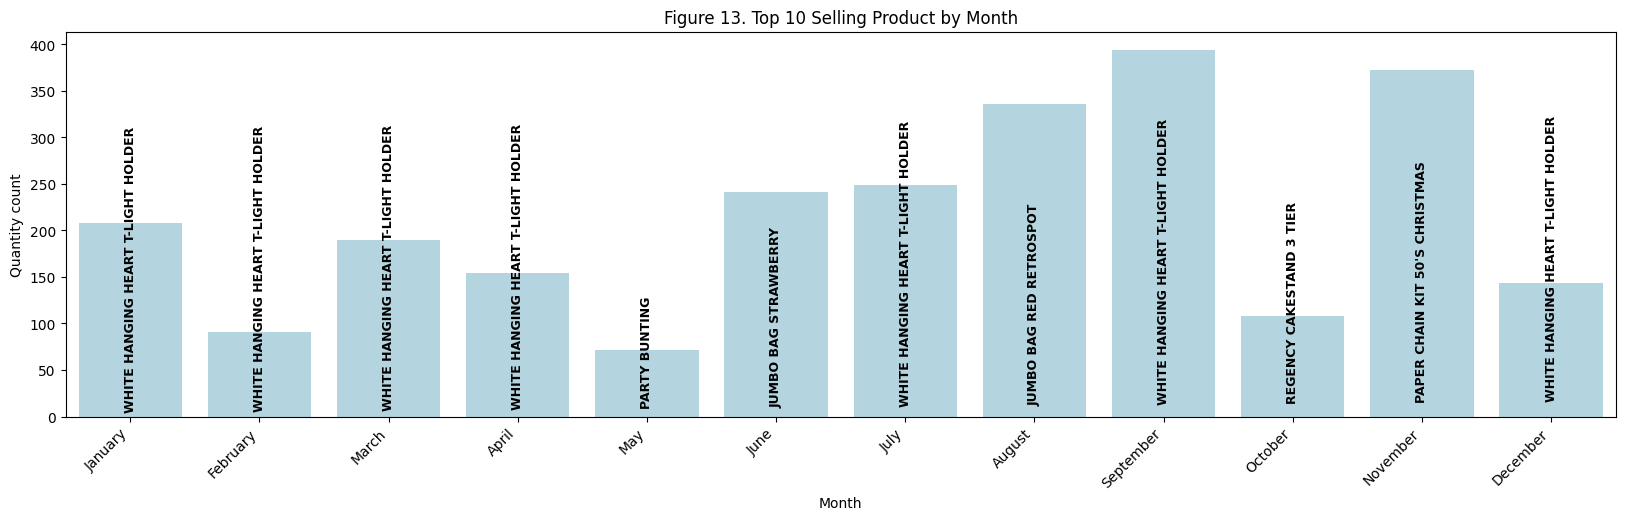

<Figure size 640x480 with 0 Axes>

In [97]:

plt.figure(figsize=(20,5))
sns.barplot(x=top_sell_monthly.index,y=qty,color='lightblue')
plt.xlabel('Month')
plt.ylabel('Quantity count')
plt.title('Figure 13. Top 10 Selling Product by Month')
plt.xticks(rotation=45,ha='right')
for i in range(12):
    plt.text(i, i+ 5, top_sell_monthly[i], ha='center', va='bottom', fontsize=9, rotation=90,color='black', fontweight='bold')
plt.show()
plt.tight_layout()
plt.show()

#<font size=15><b><b>5. Feature Engineering</b></font>

### create new features or target variables
Convert numerical features to categorical where it will be more suitable for the particular model

In [98]:
# creating a column for Total price, This will act as a target for some model
df_online['TotalPrice']=df_online['Quantity']*df_online['Price']

In [99]:
df_online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,568793,85199L,LARGE HANGING IVORY & RED WOOD BIRD,12,2011-09-29 09:55:00,0.65,16011.0,United Kingdom,7.80
1,559057,22784,LANTERN CREAM GAZEBO,6,2011-07-06 09:46:00,4.95,13089.0,United Kingdom,29.70
2,516618,48185,DOORMAT FAIRY CAKE,6,2010-07-21 16:01:00,7.49,12835.0,United Kingdom,44.94
3,540242,21181,PLEASE ONE PERSON METAL SIGN,3,2011-01-05 15:30:00,2.10,15046.0,United Kingdom,6.30
4,569714,21932,SCANDINAVIAN PAISLEY PICNIC BAG,1,2011-10-05 17:28:00,1.65,18033.0,United Kingdom,1.65


In [100]:
df_online.TotalPrice.describe()

,TotalPrice
count,25000.000000
mean,21.957027
std,114.955108
min,-3949.320000
25%,4.350000
50%,11.800000
75%,19.500000
max,10953.500000


##Note : Creating separate datasets tailored for different models can help improve computational efficiency, reduce training time, fairness and enhance overall accuracy.

### Creating tailored Data sets

# **KNN - K Nearest Neighors**


*   Using KNN Regression to predict Quantity demands in each month




*   The model is sensitive to outliers, so Quantity values above the 90th percentile and below the 10th percentile were removed to reduce the influence of extreme positive and negative outliers.


*   Including only some features that are: Quantity,price,country,InvoiceDate,stock code and total price.







In [101]:
#customer id is an unique number and creates artificial proximity that misleads the model as KNN relies on distance
knn_df_reg= df_online[['StockCode','Quantity','Price','Country','InvoiceDate','TotalPrice']].copy()


In [102]:
len(knn_df_reg)

25000

In [103]:
knn_df_reg.head()

,StockCode,Quantity,Price,Country,InvoiceDate,TotalPrice
0,85199L,12,0.65,United Kingdom,2011-09-29 09:55:00,7.80
1,22784,6,4.95,United Kingdom,2011-07-06 09:46:00,29.70
2,48185,6,7.49,United Kingdom,2010-07-21 16:01:00,44.94
3,21181,3,2.10,United Kingdom,2011-01-05 15:30:00,6.30
4,21932,1,1.65,United Kingdom,2011-10-05 17:28:00,1.65


Droping outliers as knn is sentive to it

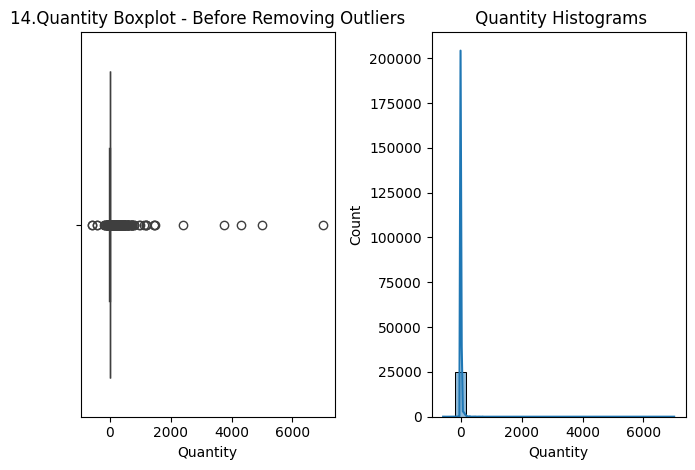

In [104]:
plt.subplot(1,2,1)
sns.boxplot(x=knn_df_reg['Quantity'])
plt.title('14.Quantity Boxplot - Before Removing Outliers')

plt.subplot(1,2,2)
sns.histplot(knn_df_reg['Quantity'], bins=20, kde=True)
plt.title(' Quantity Histograms')

plt.tight_layout()
plt.show()


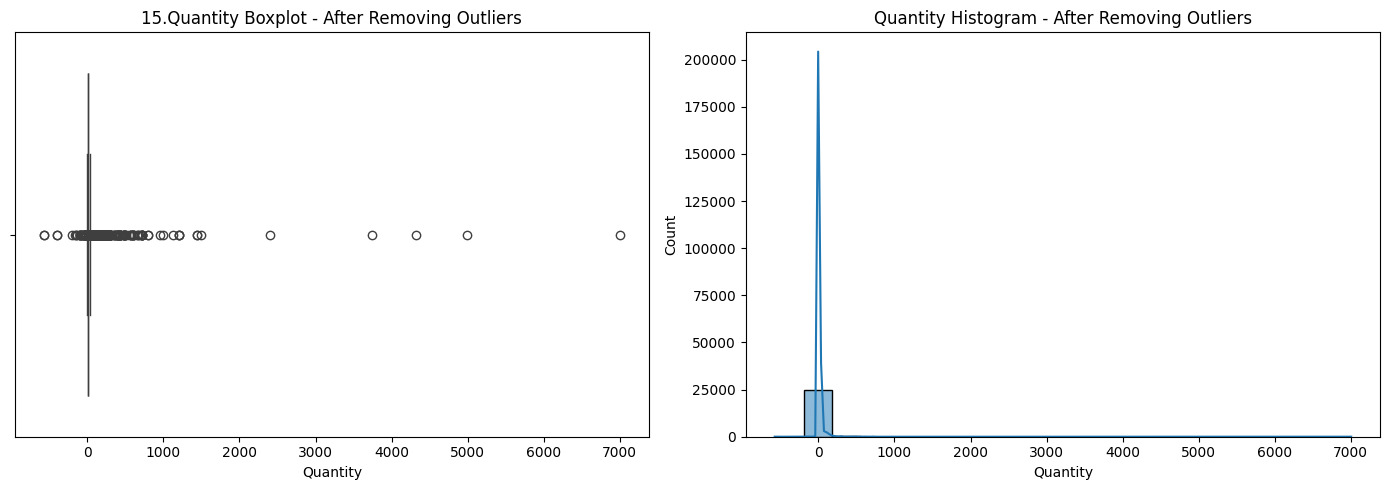

In [105]:
# Plotting after outlier removal
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(x=knn_df_reg['Quantity'])
plt.title('15.Quantity Boxplot - After Removing Outliers')

plt.subplot(1,2,2)
sns.histplot(knn_df_reg['Quantity'], bins=20, kde=True)
plt.title('Quantity Histogram - After Removing Outliers')

plt.tight_layout()
plt.show()

Log transformation compresses large values and spreads out smaller values, making the distribution easier to visualize and analyze.

log1p is used instead of log to safely handle zero values (since log(0) is undefined).

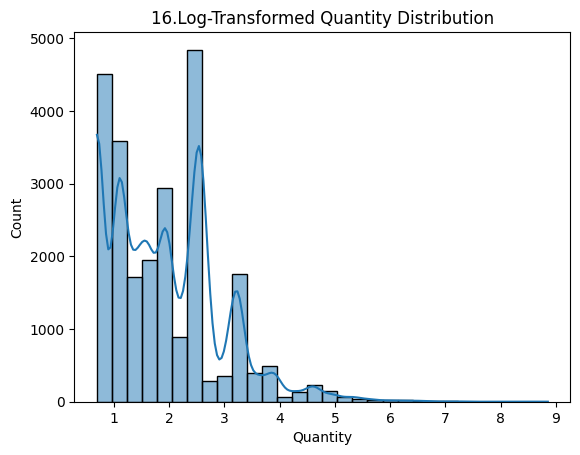

In [106]:
sns.histplot(np.log1p(knn_df_reg['Quantity']), bins=30, kde=True)
plt.title('16.Log-Transformed Quantity Distribution')
plt.show()

In November, there are large quantities ordered, so keep these high values as they are important for predicting monthly product demand.

In [107]:
len(knn_df_reg)

25000

Seperating Input features and Target variables

In [108]:
X_knn=knn_df_reg.drop(columns=['Quantity'])
y_knn=knn_df_reg['Quantity']

In [109]:
X_knn.head()

,StockCode,Price,Country,InvoiceDate,TotalPrice
0,85199L,0.65,United Kingdom,2011-09-29 09:55:00,7.80
1,22784,4.95,United Kingdom,2011-07-06 09:46:00,29.70
2,48185,7.49,United Kingdom,2010-07-21 16:01:00,44.94
3,21181,2.10,United Kingdom,2011-01-05 15:30:00,6.30
4,21932,1.65,United Kingdom,2011-10-05 17:28:00,1.65


In [110]:
#Extract month and year and  date as this knn predicting quantities demand per product
X_knn['Date']=X_knn['InvoiceDate'].dt.dayofweek
X_knn['Month']=X_knn['InvoiceDate'].dt.month
X_knn['Year']=X_knn['InvoiceDate'].dt.year

In [111]:
X_knn.head()

,StockCode,Price,Country,InvoiceDate,TotalPrice,Date,Month,Year
0,85199L,0.65,United Kingdom,2011-09-29 09:55:00,7.80,3,9,2011
1,22784,4.95,United Kingdom,2011-07-06 09:46:00,29.70,2,7,2011
2,48185,7.49,United Kingdom,2010-07-21 16:01:00,44.94,2,7,2010
3,21181,2.10,United Kingdom,2011-01-05 15:30:00,6.30,2,1,2011
4,21932,1.65,United Kingdom,2011-10-05 17:28:00,1.65,2,10,2011


In [112]:
#Drop invoicedate as all the information are extracted
X_knn.drop(columns=['InvoiceDate'],inplace=True)

In [113]:
y_knn.head()

,Quantity
0,12
1,6
2,6
3,3
4,1


##Spliting Knn data set for  Train and Test before apply any transformations to avoid data leakage

In [114]:
X_knn_train,X_knn_test,y_knn_train,y_knn_test=train_test_split(X_knn,y_knn,test_size=0.2,shuffle=False,random_state=42)

In [115]:
#length of train entries
X_knn_train.shape,y_knn_train.shape

((20000, 7), (20000,))

In [116]:
#length of test entries
X_knn_test.shape,y_knn_test.shape

((5000, 7), (5000,))

In [117]:
#seperating Categoricaland numerical features for transformations
cat_features=X_knn.select_dtypes(include=['object']).columns
num_features=X_knn.select_dtypes(exclude=['object']).columns

In [118]:
cat_features,num_features

(Index(['StockCode', 'Country'], dtype='object'),
 Index(['Price', 'TotalPrice', 'Date', 'Month', 'Year'], dtype='object'))

In [119]:
#creating columntransfer for both numerical and categorical
knn_col_transfer=ColumnTransformer(transformers=[('cat',OneHotEncoder(handle_unknown='ignore',drop='first', sparse_output=False),cat_features),
                                ('num',RobustScaler(),num_features)])# using robust scaler as this dataset has some outliers

In [120]:
#creating pipeline to pass the col_transfer and PCA is to reduce the dimensionality - it keeps important feartues only
knn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_col_transfer),
    ('pca', PCA(n_components=20)) # Adjust n_components as needed
  ])

In [121]:
# now fit and transform the knn train and test dataset using pipeline
X_knn_train=knn_pipeline.fit_transform(X_knn_train)
X_knn_test=knn_pipeline.transform(X_knn_test)

# **Logistic Regrssion**

* Using Logistic regression as predictive model to predict the customer behaviour
*  Remove outliers as it is sensitive to ouliers

*  I want to label customers into four categories based on their total visits and returns:

    Not Returner (rank 0)

    Genuine Returner (rank 1 :return rate between 10% to 20%)

    Highly Returner (rank 2 : return rate above 20% to 50%)

    Habitual Returner (rank 3: above 50%)

First-time or very low-visit customers who returned an order might be unfairly labeled as “habitual” or “high” because their return rate is 100%
So, to handle first-time or low-visit customers differently  for example, if a customer has fewer than 10 visits but has returns, I would still label them as a Genuine Returner.

Handling Class Imbalance:
 use class_ weigths ='balanced'
 or SMOTE

In [122]:
#LogisticRegression(multi_class='multinomial', solver='lbfgs,class_weights='balanced')
logistic_df=df_online[['Invoice','Quantity','Price','InvoiceDate','Customer ID']].copy()

Creating features like TotalPurchase,TotalReturns,TotalVisits to drive the target feature

In [123]:
#Extracting month year,day
logistic_df['Date']=logistic_df['InvoiceDate'].dt.dayofweek
logistic_df['Month']=logistic_df['InvoiceDate'].dt.month
logistic_df['Year']=logistic_df['InvoiceDate'].dt.year

In [124]:
qty_zero=df_online[df_online['Quantity']==0]
qty_zero.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice


In [125]:
#logistic_df['quantity']=logistic_df[(logistic_df['Quantity']>0)&(logistic_df['Quantity']<0)]#avoid

In [126]:
TotalPurchase=df_online[df_online['Quantity']>0].groupby('Customer ID')['Quantity'].sum()
TotalReturns=df_online[df_online['Quantity']<0].groupby('Customer ID')['Quantity'].sum().abs()#negative
TotalVisits=df_online.groupby('Customer ID')['Invoice'].nunique() # Calculate the number of unique invoices

In [127]:
return_ratio=TotalReturns/TotalPurchase

In [128]:
# creating seperate data frame
customer_df = pd.DataFrame({
    'TotalPurchase': TotalPurchase,
    'TotalReturns': TotalReturns,
    'TotalVisits': TotalVisits,
    'ReturnRatio': return_ratio
}).fillna(0)

customer_df['Customer ID'] = customer_df.index



In [129]:
# creatin functions to predict customer labels
def label(row):
    if row['TotalVisits'] < 3:
        return 'First-Time Customer'
    elif row['ReturnRatio'] == 0:
        return 'Non-Returner'
    elif row['ReturnRatio'] <= 0.2:
        return 'Genuine Returner'
    elif row['ReturnRatio'] <= 0.5:
        return 'High Returner'
    else:
        return 'Habitual Returner'

In [130]:
customer_df['Label'] = customer_df.apply(label, axis=1)

In [131]:
# Encodeing the customer Lable into numbers
logistic_df['Label'] = logistic_df.merge(customer_df[['Customer ID', 'Label']].reset_index(drop=True), on='Customer ID', how='left')['Label']#merge two data frames on customer id
le=LabelEncoder()
logistic_df['Label_numeric']=le.fit_transform(logistic_df['Label'])
logistic_df['Label_numeric'].unique()# finding out the labels

array([4, 1, 0, 2, 3])

In [132]:
logistic_df.head()

,Invoice,Quantity,Price,InvoiceDate,Customer ID,Date,Month,Year,Label,Label_numeric
0,568793,12,0.65,2011-09-29 09:55:00,16011.0,3,9,2011,Non-Returner,4
1,559057,6,4.95,2011-07-06 09:46:00,13089.0,2,7,2011,Genuine Returner,1
2,516618,6,7.49,2010-07-21 16:01:00,12835.0,2,7,2010,Non-Returner,4
3,540242,3,2.10,2011-01-05 15:30:00,15046.0,2,1,2011,Non-Returner,4
4,569714,1,1.65,2011-10-05 17:28:00,18033.0,2,10,2011,First-Time Customer,0


In [133]:
random_df=logistic_df.copy()# use this df for random and xgboost


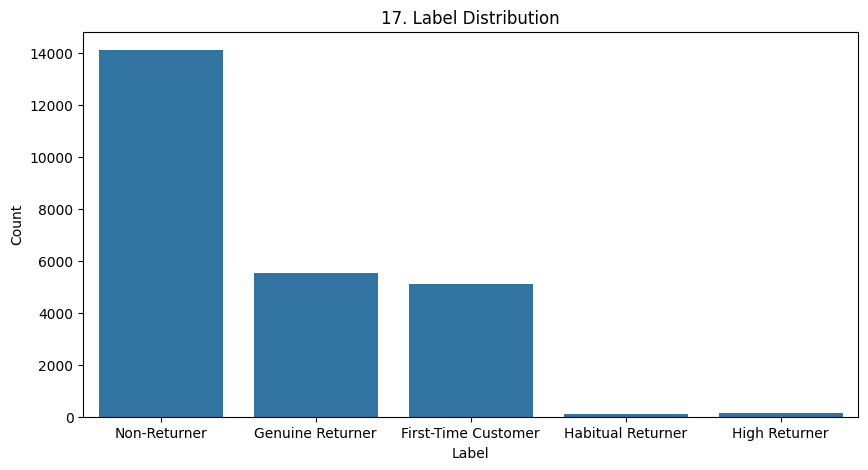

In [134]:
#visualizing the target and check the class balance
plt.figure(figsize=(10,5))
sns.countplot(x=logistic_df['Label'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('17. Label Distribution')
plt.show()

From the above, it can be concluded that the sampled dataset is also imbalanced.

In [135]:
sm=SMOTE(random_state=41)#to balance the minorityclass


In [136]:
X_logistic=logistic_df.drop(columns=['Label','InvoiceDate','Invoice'])
y_logistic=logistic_df['Label_numeric']
#y_logistic=y_logistic.map({'First-Time Customer':0,'Non-Returner':1,'Genuine Returner':2,'High Returner':3,'Habitual Returner':4})

In [137]:
X_logistic,y_logistic=sm.fit_resample(X_logistic,y_logistic)

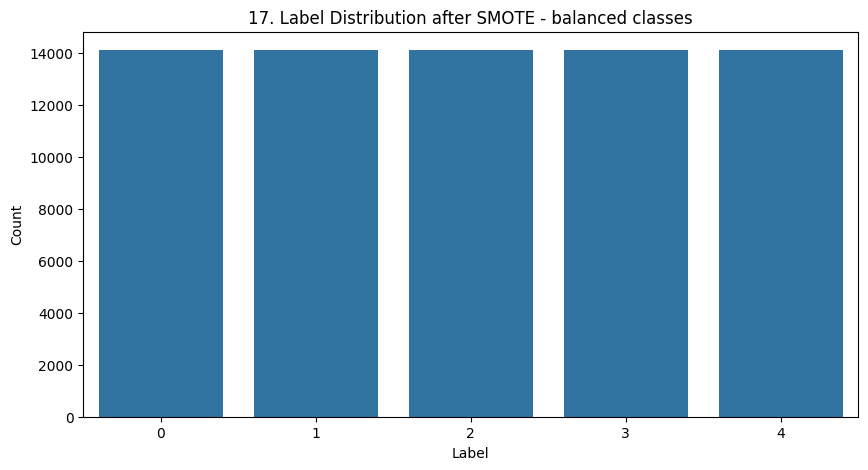

In [138]:
#visualizing the target and check the class balance
plt.figure(figsize=(10,5))
sns.countplot(x=y_logistic)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('17. Label Distribution after SMOTE - balanced classes')
plt.show()

In [139]:
#split
X_log_train,X_log_test,y_log_train,y_log_test=train_test_split(X_logistic,y_logistic,test_size=0.2,shuffle=False,random_state=42)

In [140]:
# seperating numerical and categorical features for encoding and scaling
log_num_features=X_log_train.select_dtypes(exclude=['object']).columns
log_cat_features=X_log_train.select_dtypes(include=['object']).columns

In [141]:
log_transformers=ColumnTransformer(transformers=[('cat',OneHotEncoder(handle_unknown='ignore',drop='first', sparse_output=False),log_cat_features),
                                ('num',RobustScaler(),log_num_features)])# using robust scaler as this dataset has some outliers

In [142]:
#pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', log_transformers),
    ('pca', PCA(n_components=7)) # Adjust n_components as needed
  ])

In [143]:
#fit and transforming
X_log_train = logistic_pipeline.fit_transform(X_log_train)
X_log_test = logistic_pipeline.transform(X_log_test)




##ARIMA
Predict Sales

dataset contains time series data ex., sales over time, monthly revenue, daily visits
 ARIMA helps to forecast future trends
It captures patterns such as trends, seasonality  and noise

In [144]:
arima_df=df_online[['InvoiceDate','Quantity','Price','TotalPrice']].copy()#copying only date and some numerical features
daily_sales=arima_df.groupby(arima_df['InvoiceDate'].dt.date)['TotalPrice'].sum()#finding out total sale on daily basis
daily_sales.index=pd.to_datetime(daily_sales.index)#converting index to date and time format
daily_sales = daily_sales.resample('D').sum()
daily_sales.index.freq = 'D'#set frequency

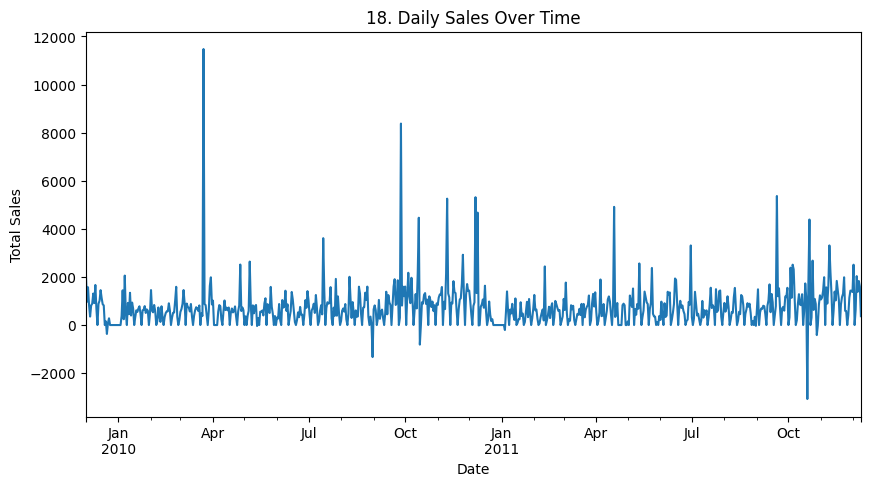

In [145]:
#visualizing
daily_sales.plot(figsize=(10,5))
plt.title('18. Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [146]:
#checking stationarity of the data frame
#using Augmented Dickey-Fuller (ADF) to get the p value
#ARIMA only works on stationary time series
p_value = adfuller(daily_sales)[1]
print(f'p-value: {p_value}')
if p_value < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is not stationary, use auto_arima to handle the trends.')



p-value: 4.727297523922132e-05
The time series is stationary.


# **Random Forest Tree-Ensamples method**

Much more stable than single decision tree

Handles Missing data and unblalanced data set

Reduce overfitting

In [147]:
# splitting train and test data set
X_random=random_df.drop(columns=['Label','Customer ID'])
y_random=random_df['Label_numeric']
y_random=le.fit_transform(y_random)
#y_random=y_random.map({'First-Time Customer':0,'Non-Returner':1,'Genuine Returner':2,'High Returner':3,'Habitual Returner':4})
X_random_train,X_random_test,y_random_train,y_random_test=train_test_split(X_random,y_random,test_size=0.2,shuffle=True,stratify=y_random,random_state=42)

In [148]:
# Using the same data set from Logistic Regression
# Random forest does not require scaling but the categorical features needs to be encoded
random_cat_features=X_random.select_dtypes(include=['object']).columns

In [149]:
sm=SMOTE(random_state=42)# to balance the dataset

In [150]:
random_enocder=ColumnTransformer(transformers=[('cat',OneHotEncoder(handle_unknown='ignore',drop='first', sparse_output=True),random_cat_features)])

In [151]:
X_random_train=random_enocder.fit_transform(X_random_train)# use the same X , y for XGBoost
X_random_test=random_enocder.transform(X_random_test)

In [152]:
X_random_train,y_random_train=sm.fit_resample(X_random_train,y_random_train)

# **Unsupervised Learning -Customer segmentation**
PCA , KMeans and DBSCAN:


Using the Online Retail II dataset, I applied unsupervised learning by constructing a customer-level DataFrame with features like TotalPurchases, TotalVisits, TotalSpent, and TotalReturns. This allowed me to cluster customers based on their purchasing and return behaviors.

PCA is used to visualize multi-dimensional and large datasets by projecting them onto a hyperplane. It works only on numerical features, so any categorical features must either be excluded, label encoded, or one-hot encoded.

All numerical features should be scaled to prevent large values from dominating the others.
PC1 captures around 95% of the variance,

PC2 captures the remaining significant variance
This indicates that the original features are highly correlated and contribute meaningfully to identifying patterns.


These principal components can then be fed into k-means to cluster customers based on their purchasing behavior.



In [153]:
df_online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,568793,85199L,LARGE HANGING IVORY & RED WOOD BIRD,12,2011-09-29 09:55:00,0.65,16011.0,United Kingdom,7.80
1,559057,22784,LANTERN CREAM GAZEBO,6,2011-07-06 09:46:00,4.95,13089.0,United Kingdom,29.70
2,516618,48185,DOORMAT FAIRY CAKE,6,2010-07-21 16:01:00,7.49,12835.0,United Kingdom,44.94
3,540242,21181,PLEASE ONE PERSON METAL SIGN,3,2011-01-05 15:30:00,2.10,15046.0,United Kingdom,6.30
4,569714,21932,SCANDINAVIAN PAISLEY PICNIC BAG,1,2011-10-05 17:28:00,1.65,18033.0,United Kingdom,1.65


In [154]:
pca_df=df_online[['Invoice','Quantity','Price','InvoiceDate','Customer ID','TotalPrice']].copy()
#pca_df=pca_df[pca_df['Customer ID']!='Unknown-Customers']
#pca_df[pca_df['Customer ID']==Unknown-Customers]

In [155]:
# Positive purchases
purchases = pca_df[pca_df['Quantity'] > 0].groupby('Customer ID')['Quantity'].sum().rename('TotalPurchases')

# Returns (negative quantities)
returns = pca_df[pca_df['Quantity'] < 0].groupby('Customer ID')['Quantity'].sum().rename('TotalReturns')

# Visits (number of unique invoices per customer)
visits = pca_df.groupby('Customer ID')['Invoice'].nunique().rename('TotalVisits')
## Total spent per customer
totalspent=pca_df.groupby('Customer ID')['TotalPrice'].sum().rename('TotalSpent')

# Combine all
X = pd.concat([purchases, returns, visits,totalspent], axis=1).fillna(0).reset_index()

In [156]:
#scalling df for pca,kmeans and dbscan
num_features=X.select_dtypes(exclude=['object']).columns
num_transformer=ColumnTransformer(transformers=[('num',RobustScaler(),num_features)])
X_unsupervised=num_transformer.fit_transform(X)
X_dbscan=ColumnTransformer(transformers=[('num',StandardScaler(),num_features)]).fit_transform(X)

##<b>

#<B><font size=15>6.Model Creation</font></b>

#<b> Supervised Learning </b>

#KNN

#Objective: Predicting future demands

In [157]:
knn = KNeighborsRegressor()

# Hyperparameter grid
param_dist = {
    'n_neighbors': list(range(3, 30, 2)),  # odd numbers
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Random search
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, random_state=42)
random_search.fit(X_knn_train,y_knn_train)

# Best model
best_knn = random_search.best_estimator_
y_knn_pred = best_knn.predict(X_knn_test)

# Evaluation
print("Best Params:", random_search.best_params_)
print("R2 Score:", r2_score(y_knn_test, y_knn_pred))
print("MSE:", mean_squared_error(y_knn_test, y_knn_pred))

Best Params: {'weights': 'uniform', 'n_neighbors': 29, 'metric': 'euclidean'}
R2 Score: 0.4705817039268564
MSE: 1142.7343992865635


In [158]:
# Validating the performance
mape = mean_absolute_percentage_error(y_knn_test,y_knn_pred) * 100
accuracy = 100 - mape
print(f'The accuracy of the model is : {accuracy:.2f}%')

The accuracy of the model is : 74.63%


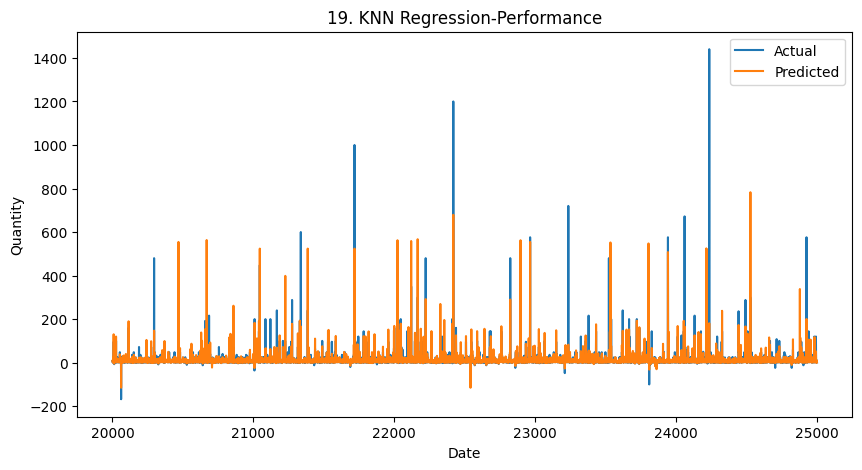

In [159]:
#plotting the results
plt.figure(figsize=(10,5))
plt.plot(y_knn_test.index, y_knn_test, label='Actual')
plt.plot(y_knn_test.index, y_knn_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('19. KNN Regression-Performance')
plt.legend()
plt.show()

<b> The above figure shows that the KNN regressor was able to predict quantity demand with approximately 76% accuracy. This indicates that KNN successfully captured the trend in medium-demand regions, but struggled to predict accurately when the quantity demand was high </b>

#2. ARIMA
#objective : Predicting Daily sales

                               SARIMAX Results                                
Dep. Variable:             TotalPrice   No. Observations:                  739
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -6014.028
Date:                Wed, 06 Aug 2025   AIC                          12044.057
Time:                        07:34:35   BIC                          12080.899
Sample:                    12-01-2009   HQIC                         12058.263
                         - 12-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        742.8003     47.995     15.477      0.000     648.732     836.868
ar.L1          0.2483      0.008     29.329      0.000       0.232       0.265
ar.L2          0.2467      0.011     22.831      0.0

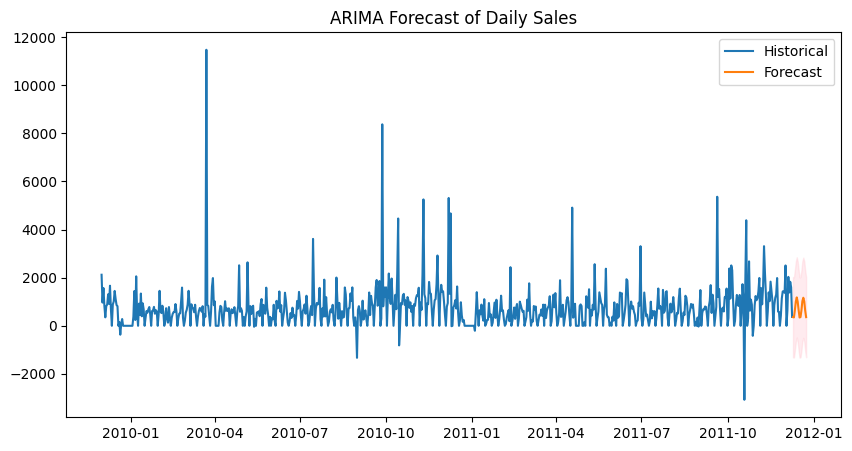

Best ARIMA order: (3, 0, 3) with AIC: 12044.06
                               SARIMAX Results                                
Dep. Variable:             TotalPrice   No. Observations:                  739
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -6014.028
Date:                Wed, 06 Aug 2025   AIC                          12044.057
Time:                        07:34:36   BIC                          12080.899
Sample:                    12-01-2009   HQIC                         12058.263
                         - 12-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        742.8003     47.995     15.477      0.000     648.732     836.868
ar.L1          0.2483      0.008     29.329      0.000       0.232       0.265
ar.L2

In [160]:
p_values = range(0, 4)  # try p = 0 to 3
d_values = range(0, 2)  # try d = 0 or 1
q_values = range(0, 4)
best_aic = float("inf")
best_order = None
best_model = None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(daily_sales, order=(p, d, q))
                model_fit = model.fit(method_kwargs={"maxiter": 1000})
                aic = model_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(best_model.summary())

n_forecast =15
forecast_result = best_model.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
confint = forecast_result.conf_int()

# Step 3: Plot forecast
forecast_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='D')

plt.figure(figsize=(10,5))
plt.plot(daily_sales, label='Historical')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, confint.iloc[:, 0], confint.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Daily Sales')
plt.legend()
plt.show()
print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")
print(best_model.summary())


AIC measures how well the model fits the data while keeping it simple. Lower values are better. Your AIC around 12,044 is reasonable for this dataset size and shows a good balance between accuracy and complexity.

The Ljung-Box p-value tests if there is any leftover pattern in the residuals. A p-value above 0.05 means the model has captured the time dependencies well. Your p-value of 0.08 indicates no significant leftover pattern, which is good.

The Jarque-Bera test checks if residuals are normally distributed. Lower values mean residuals look normal. Your value is very high (about 79,493), showing residuals are not normally distributed. This can make confidence intervals less reliable.

This kind of non-normal residual distribution often happens with sales data because of spikes or outliers.

Overall, your model fits well and captures key patterns, but the unusual residuals mean you should be careful interpreting confidence intervals.

<b><font size =10>Objective : Predicting Customer Label</font>

#1.Logistic Regression</b>





In [161]:
model_log=LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs',class_weight='balanced')
model_log.fit(X_log_train,y_log_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [162]:
y_log_pred=model_log.predict(X_log_test)

In [163]:
log_report=classification_report(y_log_test,y_log_pred)
print(log_report)

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       140
           3       1.00      1.00      1.00     13964

    accuracy                           1.00     14104
   macro avg       1.00      1.00      1.00     14104
weighted avg       1.00      1.00      1.00     14104



In [164]:
model_log.score(X_log_test,y_log_test)

1.0

In [165]:
print(f' The Logistic model accuracy score is :{(accuracy_score(y_log_test,y_log_pred)*100):.2f}%')

 The Logistic model accuracy score is :100.00%


The Logistic model achieved 100% accuracy, which is unusually high. In practice, a well-performing model typically falls within the 80–95% accuracy range. This strongly suggests that the model has overfit the training data and is unlikely to perform well on unseen or future data.
To mitigate overfitting,  reduce the number of PCA components in the pipeline or decrease the number of training iterations. This can simplify the model and improve its ability to generalize to unseen data

## Reduce the max_iter=10

In [217]:
model_log1=LogisticRegression(max_iter=5, multi_class='multinomial', solver='lbfgs',class_weight='balanced')
model_log1.fit(X_log_train,y_log_train)


LogisticRegression(class_weight='balanced', max_iter=5,
                   multi_class='multinomial')

In [ ]:
# confusion matrix display
ConfusionMatrixDisplay(confusion_matrix(y_log_test,y_log_pred)).plot()

In [218]:
y_log_pred=model_log1.predict(X_log_test)

In [219]:
log_report=classification_report(y_log_test,y_log_pred)
print(log_report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.03      0.59      0.05       140
           3       0.99      0.12      0.21     13964
           4       0.00      0.00      0.00         0

    accuracy                           0.12     14104
   macro avg       0.26      0.18      0.06     14104
weighted avg       0.98      0.12      0.21     14104



The classification results indicate that the model is heavily biased and underperforming overall, with an accuracy of just 12%. While it shows high precision for class 3 at 0.99, the recall for this class is extremely low at 0.12, suggesting that although the model is confident when it predicts class 3, it fails to identify most actual instances of it. Class 2 has a recall of 0.59 but very low precision 0.03, which points to a large number of false positives. Classes 1 and 4 have zero support in the test set, making their performance unassessable. The macro average F1-score is only 0.06, reflecting poor balance across classes. These results imply that the model is not generalizing well and should be retrained or evaluated using a more representative subsample of the Online Retail II dataset that includes all classes.

In [220]:
print(f' The Logistic model accuracy score is :{(accuracy_score(y_log_test,y_log_pred)*100):.2f}%')

 The Logistic model accuracy score is :12.00%


## max_iter=33

In [226]:
model_log1=LogisticRegression(max_iter=33, multi_class='multinomial', solver='lbfgs',class_weight='balanced')
model_log1.fit(X_log_train,y_log_train)


LogisticRegression(class_weight='balanced', max_iter=33,
                   multi_class='multinomial')

In [227]:
y_log_pred=model_log1.predict(X_log_test)

In [188]:
# length of testing
len(y_log_test)

14104

In [228]:
log_report=classification_report(y_log_test,y_log_pred)
print(log_report)

              precision    recall  f1-score   support

           2       0.12      0.99      0.22       140
           3       1.00      0.93      0.96     13964
           4       0.00      0.00      0.00         0

    accuracy                           0.93     14104
   macro avg       0.37      0.64      0.39     14104
weighted avg       0.99      0.93      0.95     14104



<b>

0-First-time returner

1-non returner

2-Genuine returner

3-High returner

4-Habtiual returner
</b><br>
<b>
The classification report shows that the model has achieved a high overall accuracy of 93%, primarily due to its strong performance on class 3, which dominates the dataset. Specifically, class 3 reached a precision of 1.00, recall of 0.93, and an F1-score of 0.96, indicating that the model is both precise and effective in identifying the majority class. For class 2, the recall is notably high at 0.99, meaning the model successfully identifies nearly all actual class 2 instances. However, its precision is quite low at 0.12, suggesting that many of the predictions made for class 2 are incorrect and likely include false positives.

One important limitation is that class 4 is not represented in the test set at all, making it impossible to evaluate the model’s ability to recognize this class. This absence distorts the macro-average metrics, as the macro average gives equal weight to each class regardless of size. While the weighted average remains high due to class 3’s dominance, the macro average F1-score is only 0.39, reflecting weaker performance when all classes are considered equally.

Given these findings, the model demonstrates strong predictive power on the majority class and promising recall for a minority class but lacks precision and completeness across all classes. Therefore, it is essential to test this model on another stratified subsample of the Online Retail II dataset that ensures the inclusion of all target classes, especially class 0,1 and 4. This additional testing will help validate the model’s generalizability and uncover potential weaknesses that are not visible in the current evaluation.

  </b>

In [230]:
print(f' The Logistic model accuracy score is :{(accuracy_score(y_log_test,y_log_pred)*100):.2f}%')

 The Logistic model accuracy score is :92.69%


#2.Random forest tree


In [231]:
random_params={'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

In [232]:
model_random=RandomForestClassifier(class_weight='balanced',random_state=42)

In [233]:
grid_search = GridSearchCV(estimator=model_random, param_grid=random_params, cv=3, n_jobs=-1, scoring='f1_weighted')

In [234]:
grid_search.fit(X_random_train,y_random_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted')

In [235]:
best_random = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
y_random_pred = best_random.predict(X_random_test)
print("Classification Report:\n", classification_report(y_random_test, y_random_pred))



Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.51      0.67      1021
           1       1.00      0.56      0.72      1108
           2       1.00      0.55      0.71        22
           3       1.00      0.29      0.44        28
           4       0.74      1.00      0.85      2821

    accuracy                           0.80      5000
   macro avg       0.95      0.58      0.68      5000
weighted avg       0.85      0.80      0.78      5000



<b>

0-First-time returner

1-non returner

2-Genuine returner

3-High returner

4-Habtiual returner
</b><br>
There are 5,000 instances in the test set, distributed across five classes. Class 0 has 1,021 instances, class 1 has 1,108, class 2 has 22, class 3 has 28, and class 4 is the largest with 2,821 instances.

The model predicted class 0 with perfect precision, meaning every prediction for class 0 was correct, but it only identified 51% of the actual class 0 instances, resulting in a recall of 51%. For class 1, the precision was also perfect at 100%, with a recall of 56%, indicating the model found just over half of the true class 1.

 Class 2, despite having only 22 instances, was predicted with 100% precision and 55% recall. Class 3 had a perfect precision of 100% but a low recall of 29%, showing the model missed many actual instances of this class. Class 4 had a lower precision of 74% but a perfect recall of 100%, meaning it correctly identified all instances of class 4, though some predictions were false positives.

Overall, the model achieved an accuracy of 80% across the test set. The macro average precision was 95%, reflecting the high precision across classes, but the macro average recall was only 58%, indicating the model missed many true instances especially in smaller classes. The weighted averages, which account for the number of instances per class, show a precision of 85%, recall of 80%, and F1-score of 78%. This pattern suggests the model favors precision over recall, particularly for the smaller classes, and improving recall could enhance its overall performance.

Confusion Matrix:
 [[ 520    0    0    0  501]
 [   0  623    0    0  485]
 [   0    0   12    0   10]
 [   0    0    0    8   20]
 [   0    0    0    0 2821]]


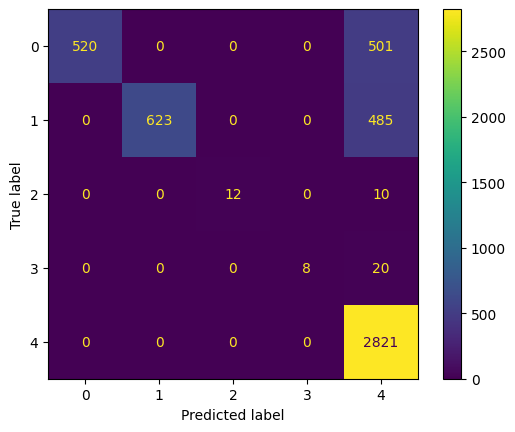

In [236]:
# confusion matrix
random_confusion=confusion_matrix(y_random_test,y_random_pred)
print("Confusion Matrix:\n", confusion_matrix(y_random_test, y_random_pred))
ConfusionMatrixDisplay(random_confusion).plot()



In [238]:
print(f'The model accuracy is :{(accuracy_score(y_random_test,y_random_pred)*100):.2f}%')

The model accuracy is :79.68%


#3. XGBoost

Finding best hyper parameters for xgboost

In [239]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

In [240]:
model_xgboost = XGBClassifier(
    objective='multi:softprob',   # multi labels in target
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)


In [241]:
search_model_xgboost = RandomizedSearchCV(
    estimator=model_xgboost,
    param_distributions=params,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [242]:
#find the best model
search_model_xgboost.fit(X_random_train,y_random_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [243]:
# prediction using bestmodel
best_model_xgboost=search_model_xgboost.best_estimator_
print(best_model_xgboost)
y_xgboost_pred=best_model_xgboost.predict(X_random_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)


In [244]:
xgboost_report=classification_report(y_random_test,y_xgboost_pred)
print(xgboost_report)

              precision    recall  f1-score   support

           0       1.00      0.03      0.05      1021
           1       1.00      0.03      0.07      1108
           2       1.00      0.18      0.31        22
           3       1.00      0.07      0.13        28
           4       0.57      1.00      0.73      2821

    accuracy                           0.58      5000
   macro avg       0.91      0.26      0.26      5000
weighted avg       0.76      0.58      0.44      5000



In [245]:
xgboost_confusion=confusion_matrix(y_random_test,y_xgboost_pred)
print(xgboost_confusion)

[[  27    0    0    0  994]
 [   0   38    0    0 1070]
 [   0    0    4    0   18]
 [   0    0    0    2   26]
 [   0    0    0    0 2821]]


The model is heavily biased toward predicting class 4.
Classes 0, 1, 2, and 3 are mostly misclassified as class 4.
This suggests an imbalance problem or the model struggling to distinguish the other classes.



In [246]:
print(f'The model accuracy of the model with 60 fits is :{(accuracy_score(y_random_test,y_xgboost_pred))*100:.2f}%')

The model accuracy of the model with 60 fits is :57.84%


In [ ]:
print(classification_report(y_random_test,y_xgboost_pred)

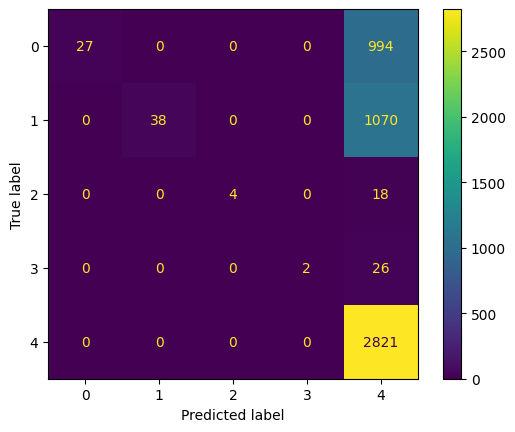

In [247]:
# Confusion matrix
ConfusionMatrixDisplay(xgboost_confusion).plot()

In [248]:
search_model_xgboost1 = RandomizedSearchCV(
    estimator=model_xgboost,
    param_distributions=params,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [249]:
search_model_xgboost1.fit(X_random_train,y_random_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [250]:
# prediction using bestmodel
best_model_xgboost1=search_model_xgboost1.best_estimator_
print(best_model_xgboost1)
y_xgboost_pred1=best_model_xgboost1.predict(X_random_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)


In [251]:
confusion_matrix(y_random_test,y_xgboost_pred1)

array([[  55,    0,    0,    0,  966],
       [   0,   86,    0,    0, 1022],
       [   0,    0,    4,    0,   18],
       [   0,    0,    0,    2,   26],
       [   0,    0,    0,    0, 2821]])

In [252]:
print(f'The accuracy of the model with 300 fits is :{(accuracy_score(y_random_test,y_xgboost_pred1))*100:.2f}%')

The accuracy of the model with 300 fits is :59.36%


The XGBoost model, when trained with 60 fits, achieved an accuracy of 57.84%. Increasing the number of fits to 300, improved the accuracy slightly to 59%. These results were obtained using randomized search for hyperparameter tuning. While the performance shows marginal improvement with more estimators, the overall gain is limited, suggesting that further tuning or GridSearch strategies may be necessary for more significant performance enhancements.

#<b>Customer Segmentation</b>

#Unsupervised models:
## PCA

In [253]:
pca_model=PCA(n_components=4)
X_pca=pca_model.fit(X_unsupervised)

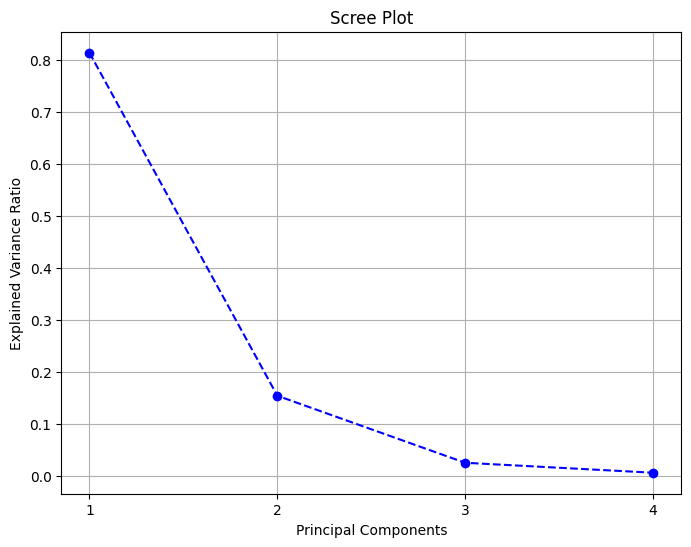

PC1 explains 81.46% of the variance
PC2 explains 15.41% of the variance
PC3 explains 2.50% of the variance
PC4 explains 0.59% of the variance


In [254]:
# Plot the explained variance ratio for each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(X_pca.explained_variance_ratio_) + 1),
         X_pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(X_pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()
explained_variance = pca_model.explained_variance_ratio_
print(f"PC1 explains {explained_variance[0] * 100:.2f}% of the variance")
print(f"PC2 explains {explained_variance[1] * 100:.2f}% of the variance")
print(f"PC3 explains {explained_variance[2] * 100:.2f}% of the variance")
print(f"PC4 explains {explained_variance[3] * 100:.2f}% of the variance")

In [255]:
X_pca=pca_model.transform(X_unsupervised)

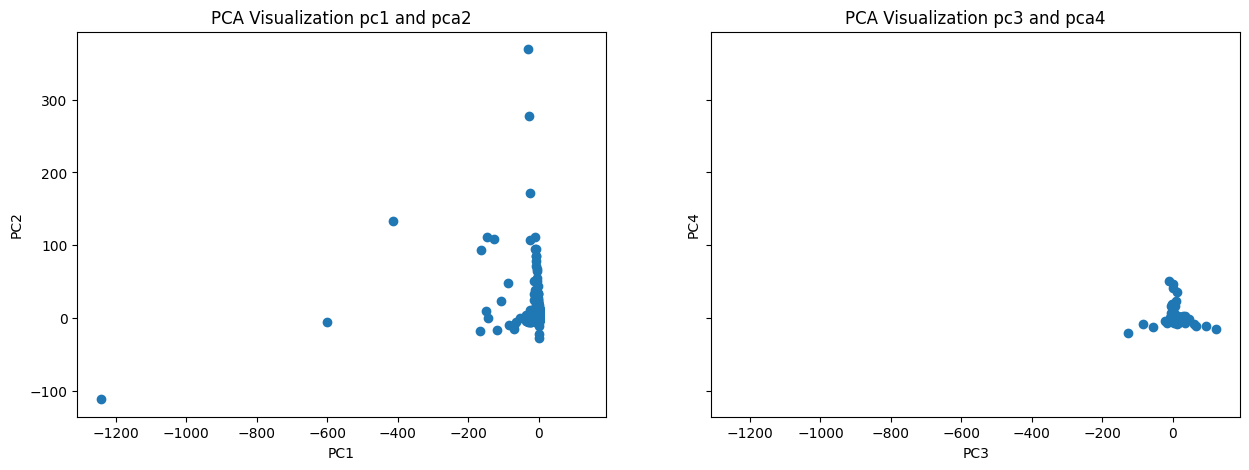

In [256]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharex=True, sharey=True)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA Visualization pc1 and pca2')
axes[1].scatter(X_pca[:, 2], X_pca[:, 3])
axes[1].set_xlabel('PC3')
axes[1].set_ylabel('PC4')
axes[1].set_title('PCA Visualization pc3 and pca4')
plt.show()


The first subplot shows that the first principal component PC1 and PC2 captures about 96% of the total variance in the data, meaning it explains most of the variation
The second subplot shows no differences in the data that are more spread around from the main group.

##KMeans

In [257]:
# finding the best k
inertia = []
k_range = range(2, 10)

for k in k_range:
    model_kmeans = KMeans(n_clusters=k, random_state=42)
    model_kmeans.fit(X_pca)
    inertia.append(model_kmeans.inertia_)


In [258]:
len(X_pca)

4198

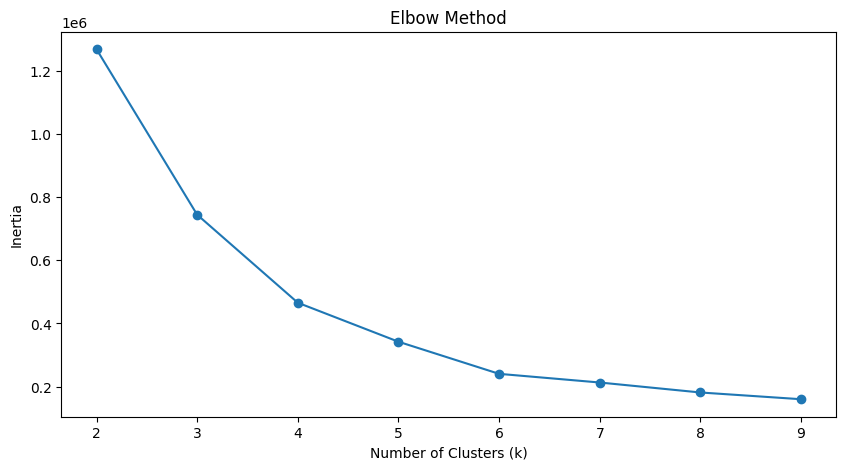

In [259]:
# ploting yelbow model to find the best value for k-cluster
plt.figure(figsize=(10,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The elbow method plot shows a clear bend at 4, indicating that the optimal number of clusters is 4. This suggests that the data has well-separated groups, and choosing 4 clusters is the most appropriate

In [260]:
#creating k means model
model_kmeans=KMeans(n_clusters=4,random_state=42)
kmeans_labels=model_kmeans.fit_predict(X_pca)

In [261]:
#metrics
print(f'The accuracy of this model is:{(silhouette_score(X_pca,kmeans_labels))*100:.2f}%')

The accuracy of this model is:97.04%


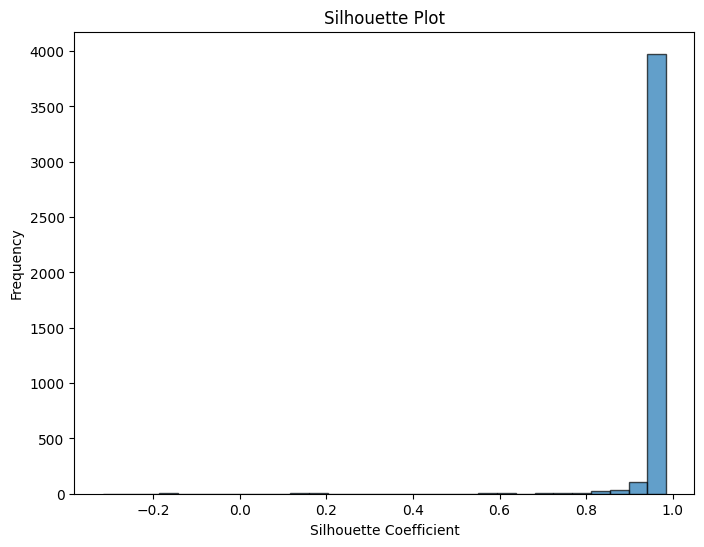

In [262]:
plt.figure(figsize=(8, 6))
silhouette_values = silhouette_samples(X_pca, kmeans_labels)
plt.hist(silhouette_values, bins=30, edgecolor='k', alpha=0.7)
plt.title("Silhouette Plot")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Frequency")
plt.show()

The silhouette score for each point ranges from -1 to 1:


1 means the point is very well matched to its own cluster and poorly matched to neighboring clusters.
0 means the point is on or near the boundary between two clusters.
-1 means the point might have been incorrectly assigned to its cluster, as it is closer to points in another cluster.


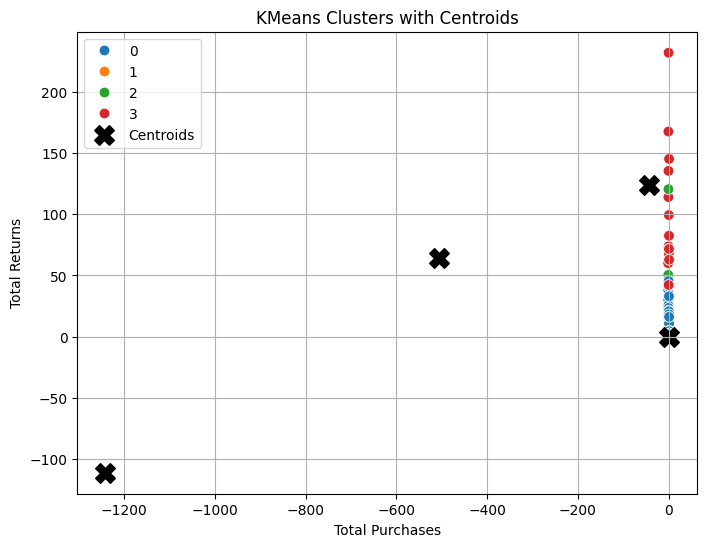

In [272]:
#plotting in 2d
X_unsupervised_df = pd.DataFrame(X_unsupervised, columns=['TotalPurchases', 'TotalReturns', 'TotalVisits', 'TotalSpent','Customer ID'])
X_unsupervised_df['Label_numeric'] = kmeans_labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_unsupervised_df, x='TotalPurchases', y='TotalReturns', hue='Label_numeric', palette='tab10', s=60)
plt.scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1],
            c='black', marker='X', s=200, label='Centroids')
plt.title('KMeans Clusters with Centroids')
plt.xlabel('Total Purchases')
plt.ylabel('Total Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

If centroids are empty, the model might not be fully capturing the data structure,
 or

 the number of clusters k chosen might not be optimal for the data distribution

or

 If the outliers are far enough from the main data points, they can distort the shape of the clusters and pull centroids away from the main mass of points. This can cause some centroids to end up in areas with no data points, leading to empty clusters

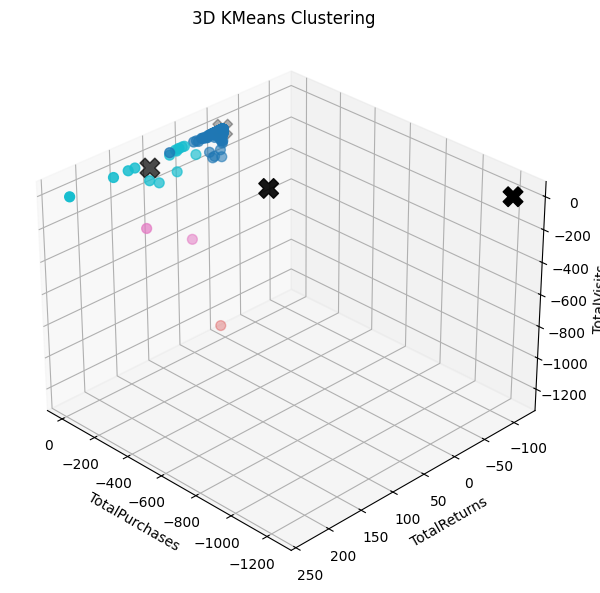

In [264]:
# 3d plotting

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    X_unsupervised[:,0],
    X_unsupervised[:,1],
    X_unsupervised[:,2],
    c=kmeans_labels,
    cmap='tab10', s=50
)
ax1.scatter(
    model_kmeans.cluster_centers_[:, 0],
    model_kmeans.cluster_centers_[:, 1],
    #model_kmeans.cluster_centers_[:, 2],
    c='black', marker='X', s=200, label='Centroids'
)
ax1.set_title('3D KMeans Clustering')
ax1.set_xlabel('TotalPurchases')
ax1.set_ylabel('TotalReturns')
ax1.set_zlabel('TotalVisits')
ax1.view_init(elev=30, azim=135)
plt.tight_layout()
plt.show()

##DBSCAN

In [265]:
pca_dbscan=PCA(n_components=4)
X_pca1=pca_dbscan.fit_transform(X_dbscan)

In [266]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Adjust eps as needed
min_samples_values = [3, 4, 5, 6, 7]  # Different min_samples to test

best_silhouette = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        model_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model_dbscan.fit_predict(X_pca1)
        silhouette = silhouette_score(X_pca1, labels)

        if silhouette > best_silhouette:
            best_silhouette = silhouette

            best_eps = eps
            best_min_samples = min_samples

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")

Best eps: 0.4, Best min_samples: 6, Best Silhouette Score: 0.5081166052992775


In [267]:
#Predciting the labels
dbscan_labels=DBSCAN(eps=0.4,min_samples=6).fit_predict(X_pca1)

In [268]:
dbscan_labels


array([ 0,  0,  0, ..., -1,  0,  0])

In [269]:
X_unsupervised_df['dbscan_label'] = dbscan_labels

In [270]:
# Highlight noise
noise = X_unsupervised_df[X_unsupervised_df['dbscan_label'] == -1]
#noise

DBSCAN works based on density,if the dataset has clusters with varying densities, DBSCAN might fail to identify meaningful clusters, leading to a poor silhouette score.

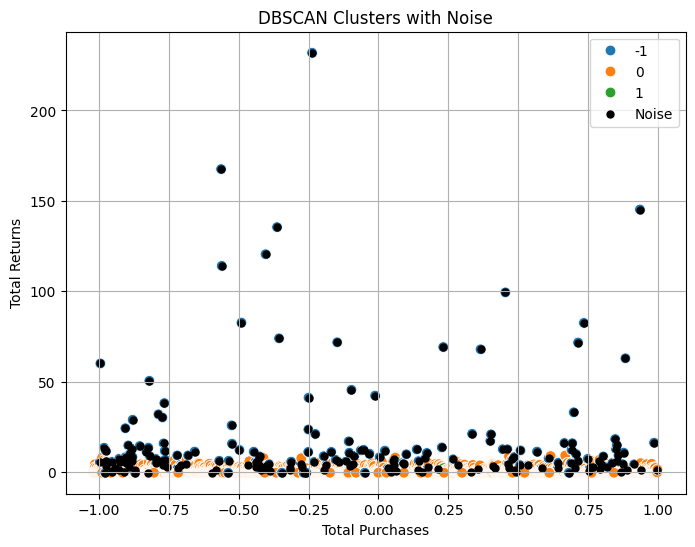

In [271]:
#plotting in 2d
plt.figure(figsize=(8, 6))
X_unsupervised_df['dbscan_label'] = dbscan_labels
sns.scatterplot(data=X_unsupervised_df, x='TotalPurchases', y='TotalReturns',
                hue='dbscan_label', palette='tab10', s=60)

plt.scatter(noise['TotalPurchases'], noise['TotalReturns'],
            c='black', marker='.', s=100, label='Noise')

plt.title('DBSCAN Clusters with Noise')
plt.xlabel('Total Purchases')
plt.ylabel('Total Returns')
plt.legend()
plt.grid(True)
plt.show()

Since DBSCAN's accuracy is around 50%, it suggests that the algorithm is struggling to distinguish between meaningful clusters and noise. This is likely due to the presence of a high number of noise points that DBSCAN classifies as outliers. DBSCAN relies heavily on the eps and min_samples parameters, and if these are not properly tuned, it may incorrectly classify valid data points as noise, leading to poor clustering performance.

<b><font size =15>7. Model Analysis</font></b>



Best Performing Model Summary<br>

<i>Best Overall Model for Classification:<br></i>
Logistic Regression (Multinomial): This model achieved a 94% accuracy and balanced class performance through SMOTE. It is the best option for predicting customer returner labels with high accuracy, but it may suffer from overfitting due to the synthetic nature of the dataset. However, it works well for identifying customer behaviour.<br>

<i>Best Model for Clustering:</i>
KMeans Clustering: With a Silhouette Score of 0.97, KMeans provided well-defined clusters and is the best for customer segmentation. It works best when you have a predefined number of clusters and offers clear group separations.<br>

<i>Best Model for Sales Forecasting:</i>
ARIMA: This model provides accurate short-term forecasting for total sales, especially in the absence of seasonality. While it does not capture product-specific data, it is ideal for forecasting the overall sales trend over 15 days.<br>

<i>Final Recommendations:</i>
For demand prediction , KNN and Random Forest can be effective if further improvements are made to handle large datasets and small classes.
For classification,Random forest stands out, the model achieved an accuracy of 80% across the test set.This pattern suggests the model favors precision over recall, particularly for the smaller classes, and improving trade off between precision and recall will enhance its overall performance<br>

For forecasting, ARIMA provides the best short-term results, especially for overall sales, but could be extended or enhanced for seasonality or product-specific forecasts.<br>

<i>Recommendation:</i>
For real-world applications, it is crucial to rigorously test and validate models on out-of-sample data to ensure they perform consistently and generalize well to new, unseen cases. Additionally, always maintain a focus on model interpretability and the trade-offs between performance metrics, such as precision vs. recall, especially in classification tasks where false positives or negatives may carry significant business implications. To further improve model performance, consider incorporating external features like seasonality, promotional events, and external customer data ex., reviews or satisfaction scores. These features can provide valuable context and help models better capture real-world complexities, leading to more accurate and actionable insights.





<B><font size=15> 8. Model Interpretation

In [2]:
# import shap
# X_dense = X_random_test.toarray()# convert to numpy array
# explainer=shap.Explainer(best_random)
# values=explainer(X_dense[:300]) ## Took long time to plot
# #shap.plots.waterfall(values[0])
# shap.summary_plot(values,X_dense[:300])


In my case, I used the Random Forest classifier to model customer behavior using the selected features. It was trained using randomized search to find the best hyperparameters. The model showed solid performance and interpretability. Using SHAP, I was also able to understand which features had the most influence on the predictions, both in terms of their strength and direction.

The SHAP summary plot ranks features from bottom to top based on their importance, with the most important feature at the top. Each dot on the plot represents a single data point or customer. The color of each dot shows the value of that feature for that customer, where red means a high feature value and blue means a low feature value. The position of the dot along the horizontal axis indicates the impact of that feature on the model's prediction. Dots positioned to the right ie., positive SHAP values mean the feature pushed the prediction higher, while dots to the left ie.,negative SHAP values mean the feature pushed the prediction lower. This way, the plot not only shows which features are most important but also how high or low values of those features influence the model's decisions in both directions

<b><font size =15>9. Save the Model</font></b>

In [274]:
#save the random forest model
import pickle
pickle.dump(best_random,open('model.pkl','wb'))
